In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# We are working on this project in google colab, hence the pip install
!pip install dgl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 6.7 MB/s 
     |████████████████████████████████| 280 kB 46.7 MB/s 
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [35]:
# Import the related libraries
import pandas as pd
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import os
import torch
import dgl
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
from dgl.nn.pytorch import conv as dgl_conv
from dgl.nn.pytorch.glob import SumPooling
import warnings
warnings.filterwarnings('ignore')

In [36]:
# Import the training data
csv_pds = []
dates = []
for file in os.listdir("/content/drive/MyDrive/COMP 4222/data_Feb1_Mar31"):
    if file.endswith(".csv"):
        csv_pds.append(pd.read_csv("/content/drive/MyDrive/COMP 4222/data_Feb1_Mar31/"+file,on_bad_lines="skip"))
        dates.append(file[0:8])

In [37]:
# Preprocessing of our data
# Since the covid data we obtain from the HK gov website has some minor typo in their district names,
# we use a sequence matcher to match the closest name to the district defined in the districts array
from difflib import SequenceMatcher
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

districts = ['Central & Western', 'Eastern', 'Islands', 'Kowloon City', 'Kwai Tsing',
 'Kwun Tong', 'North', 'Sai Kung', 'Sham Shui Po', 'Sha Tin', 'Southern',
 'Tai Po', 'Tsuen Wan', 'Tuen Mun', 'Wan Chai', 'Wong Tai Sin', 'Yau Tsim Mong',
 'Yuen Long']

iter =0
for csv in csv_pds:
  csv["District"] = csv.apply(lambda row: districts[np.argmax(np.array([similar(row["District"],key) for key in districts]))], axis=1)
  count = csv['District'].unique()
  if len(count) != 18:
    print("failed entry recorded") 
  print(iter, end=" ")
  iter +=1

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 

In [38]:
series_count_district ={}
for district in districts:
    series_count_district[district] = []

In [39]:
for pd in csv_pds:
    for district in districts:
          series_count_district[district].append((pd['District'] == district).sum())

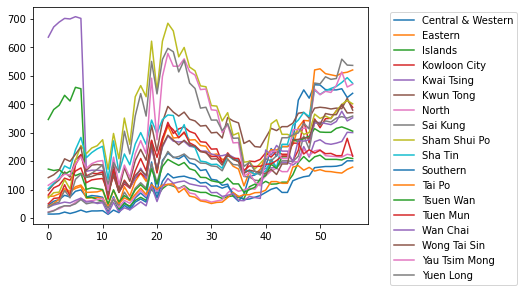

In [40]:
# Plot the series_count_district data to have an overview 
for district in series_count_district:
    plt.plot(series_count_district[district], label=district)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [41]:
# Create the pearson correlation matrix
district_series = []
for district in districts:
  district_series.append(series_count_district[district])
correlation = np.corrcoef(district_series, district_series)
useful_correlation = correlation[0:18,0:18]
connection_threshold = 0.81 # hyper parameter
window_size = 4 # hyper parameter
adjacency_matrix = np.where(useful_correlation > connection_threshold, 1, 0)

In [42]:
adjacency_matrix

array([[1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0],
       [1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0],
       [1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0],
       [1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0],
       [1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1],
       [1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0],
       [1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,

In [43]:
temporal_adjacency_matrix = np.tile(adjacency_matrix,(window_size, window_size))
tight_temporal_adjacency_matrix = temporal_adjacency_matrix
for i in range(18):
  for j in range(3):
    if(i+j*18 < 18*4):
      position = i+j*18
      tight_temporal_adjacency_matrix[i][position]=1
      tight_temporal_adjacency_matrix[position][i]=1 

In [ ]:
a = dict(zip(range(18), districts))
print(a)

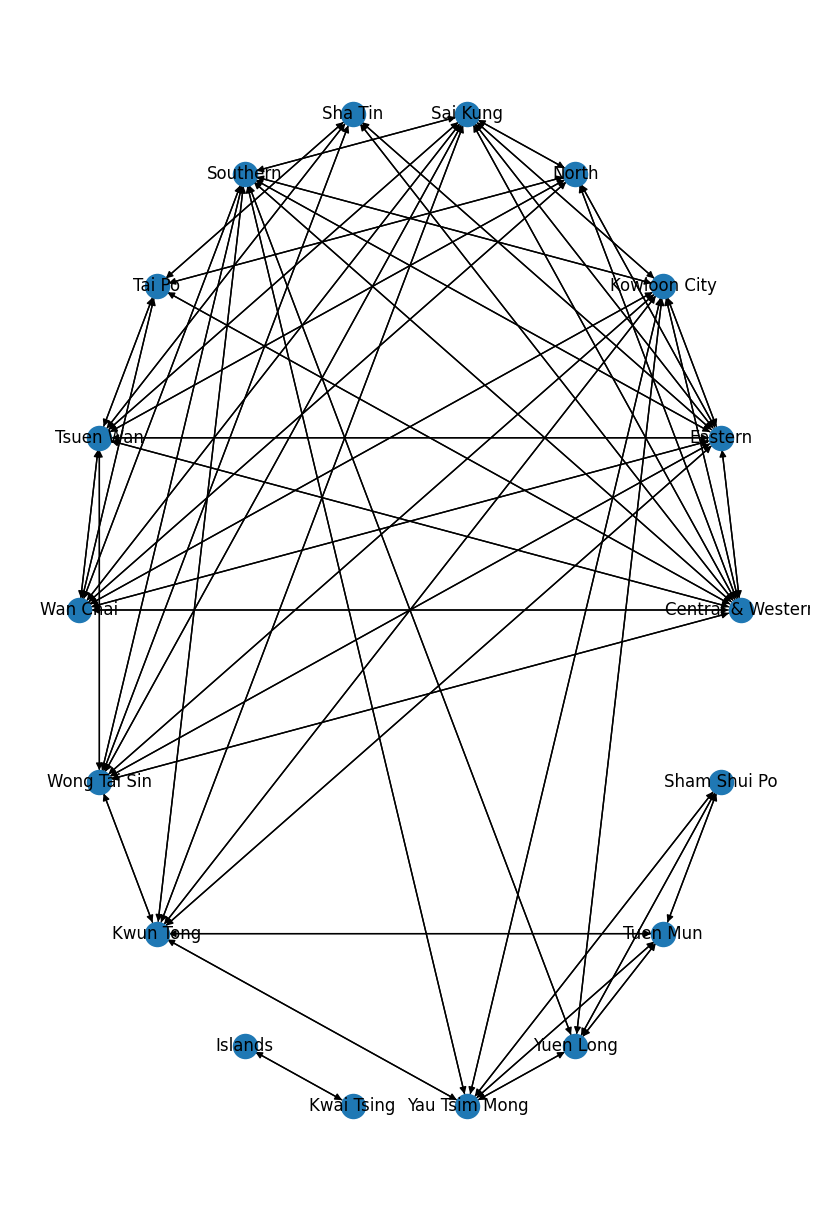

In [ ]:
# !pip install networkx
import networkx as nx
from matplotlib.pyplot import figure
figure(figsize = (8,12),dpi=100)
G = nx.DiGraph()
for i in range(18):
  for j in range(18):
    if adjacency_matrix[i,j] == 1 and i != j:
      G.add_edge(i,j)
G = nx.relabel_nodes(G, dict(zip(range(18), districts)))
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True)
plt.savefig("/content/drive/MyDrive/COMP 4222/covid_graph.svg",dpi= 100)
plt.show()

In [ ]:
# !pip install networkx
import networkx as nx
from matplotlib.pyplot import figure
figure(figsize = (8,12),dpi=100)
G = nx.DiGraph()
for i in range(72):
  for j in range(72):
    if temporal_adjacency_matrix[i,j] == 1 and i != j:
      G.add_edge(i,j)
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True)
plt.savefig("/content/drive/MyDrive/COMP 4222/temporal_covid_graph.svg",dpi= 100)
plt.show()

In [ ]:
# !pip install networkx
import networkx as nx
from matplotlib.pyplot import figure
figure(figsize = (8,12),dpi=100)
G = nx.DiGraph()
for i in range(72):
  for j in range(72):
    if tight_temporal_adjacency_matrix[i,j] == 1 and i != j:
      G.add_edge(i,j)
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True)
plt.savefig("/content/drive/MyDrive/COMP 4222/tight_temporal_covid_graph.svg",dpi= 100)
plt.show()

In [44]:
# Create the covid dgl graph
r,c = np.nonzero(adjacency_matrix==1)
covid_graph = dgl.graph((r,c),num_nodes=18)
# covid_graph.ndata['cases'] = torch.ones(covid_graph.num_nodes(),4)
r_temporal, c_temporal = np.nonzero(temporal_adjacency_matrix==1)
temporal_covid_graph = dgl.graph((r_temporal, c_temporal))

r_tight_temporal, c_tight_temporal = np.nonzero(tight_temporal_adjacency_matrix==1)
tight_temporal_covid_graph = dgl.graph((r_tight_temporal, c_tight_temporal))

# print(temporal_covid_graph.num_nodes())


In [45]:
print(adjacency_matrix)

[[1 1 0 1 0 0 1 1 0 1 1 1 1 0 1 1 0 0]
 [1 1 0 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0]
 [0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 1 0 1 0 1 0 0 1 0 0 0 1 1 1 1]
 [0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 0 1 0 0 1 0 0 1 0 1 1 0]
 [1 1 0 0 0 0 1 1 0 0 0 1 1 0 1 0 0 0]
 [1 1 0 1 0 1 1 1 0 0 1 0 1 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1]
 [1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0]
 [1 1 0 1 0 1 0 1 0 0 1 0 0 0 1 1 1 1]
 [1 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0]
 [1 1 0 0 0 0 1 1 0 1 0 1 1 0 1 1 0 0]
 [0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 1]
 [1 1 0 1 0 0 1 1 0 0 1 1 1 0 1 0 0 0]
 [1 1 0 1 0 1 0 1 0 1 1 0 1 0 0 1 0 0]
 [0 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 1 1]
 [0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 1 1]]


In [24]:
# Our graph sage model
class COVID_GraphSage(nn.Module):
  def __init__(self, in_feats, n_hidden, out_dim,activation,dropout,aggregator_type='mean',n_layers=2):
    super(COVID_GraphSage, self).__init__()
    self.layers = nn.ModuleList()
    #input layer 
    self.layers.append(dgl_conv.SAGEConv(in_feats, n_hidden, aggregator_type, feat_drop=dropout, activation=activation))
    
    #hidden layers 
    for i in range(n_layers-2):
      self.layers.append(dgl_conv.SAGEConv(n_hidden, n_hidden, aggregator_type, feat_drop=dropout, activation=activation))
    
    #output_layer
    self.layers.append(dgl_conv.SAGEConv(n_hidden, out_dim, aggregator_type, feat_drop=dropout, activation=None))
  
    self.d2_pool =(nn.MaxPool1d(1, stride=6))
    # #produces 6*6
    self.d1_pool = ( nn.MaxPool1d(1,stride=4))
    #returns an 18*1
    # self.pool = SumPooling()
    
  def forward(self, g, features):
    h = features
    for layer in self.layers:
      h = layer(g, h)
    h = self.d2_pool(h)
    h = self.d1_pool(h)
    return h

In [ ]:
# Creating the sliding window as training data
window_size = 4
input_dim = (18,4) #past 4 historic cases for all nodes
output_dim = 18 #covid case prediction for each nodes 
# fifth value is the true value to compare, ie validation

modified_input = []
modified_val = []

for sequence in district_series:
    input_sequence = [sequence[i:i+window_size] for i in range(0,len(sequence)-window_size)]
    val_sequence = [[sequence[i+window_size] for i in range(0,len(sequence)-window_size)]]
    modified_input.append(input_sequence)
    modified_val.append(np.array(val_sequence))

modified_input = np.array(modified_input)
modified_val=  np.array(modified_val)
modified_val = modified_val.reshape(18,-1,1)
modified_input =np.array([modified_input[:,x,:] for x in range(len(sequence)-window_size)])
modified_val = np.array([modified_val[:,x,:] for x in range(len(sequence)-window_size)])
temporal_input = modified_input.reshape(modified_input.shape[0],-1)
temporal_val = np.squeeze(np.concatenate((np.expand_dims(modified_input[:,:,-3], axis=2),np.expand_dims(modified_input[:,:,-2], axis=2),np.expand_dims(modified_input[:,:,-1], axis=2),modified_val),axis=1))

In [ ]:
print(modified_input.shape)
print(modified_val.shape)
print(temporal_input.shape)
print(temporal_val.shape)

(53, 18, 4)
(53, 18, 1)
(53, 72)
(53, 72)


In [25]:
# Create the COVID_GraphSage with the layer defined below
in_feats = 4 #input features, which is our sliding window size
n_layers = 3 #1 input, 1 hidden, 1 output
n_hidden = 10
dropout = 0.5
input_dim = (18,4) #past 4 historic cases for all nodes
temporal_input_dim = 72
output_dim = 18 #covid case prediction for each nodes 
# fifth value is the true value to compare, ie validation

In [58]:
# Classes and functions to train and evaluate our model
# Our evaluation method is based on Symmetric mean absolute percentage error (SMAPE)
# More details on https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error
from dgl.dataloading import SAINTSampler, DataLoader
losses= []
class COVID_Sage_Case(nn.Module):
  def __init__(self, COVID_Sage_Model, n_hidden):
    super(COVID_Sage_Case, self).__init__()
    self.COVID_Sage_Model = COVID_Sage_Model 
    self.loss_fcn = torch.nn.MSELoss()

  def forward(self, g, features, label):
    features = torch.tensor(features, dtype=torch.double)
    logits = self.COVID_Sage_Model(g, features)
    return self.loss_fcn(logits.double(), label.double())

def COVID_Evaluate(model, g, features, labels, isTemporal=False):
  model.eval()
  with torch.no_grad():
    if isTemporal:
      features = torch.unsqueeze(features, 1)
    logits = model.COVID_Sage_Model(g, features)
    # print("I reach here")
    logits = logits.reshape(-1)
    labels = labels.reshape(-1)
    #only abstract out the future prediction from the temporal graph
    if isTemporal:
      logits = logits[-17:]
      labels = labels[-17:]
    acc = np.sum(np.abs(np.array(logits)-np.array(labels))/(np.abs(np.array(logits))+np.abs(np.array(labels))))/logits.shape[0]
  return acc, np.array(logits)

def Train(model, graph, features, labels, n_epochs, optimizer):
  for epoch in range(n_epochs):
    model.train()
    acc =0
    for i in range(features.shape[0]):
      x = torch.tensor(features[i], dtype=torch.double)
      y = torch.tensor(labels[i], dtype=torch.double)
      # print(features.size, "Size of y", labels.size, "Size of x")
      loss = model(graph,x,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      acc,forecast = COVID_Evaluate(model, graph, x, y)
    print(f"Epoch: {epoch}, Loss: {loss.item()}, SMAPE: {acc}")
    losses.append(loss.item())
#modes are node, edge, walk
def TrainDynamic(model, graph, features, labels, n_epochs, optimizer, num_iters=10, mode="node"):
    if mode == "walk":
      sampler = SAINTSampler(mode=mode, budget=(graph.number_of_nodes(), window_size))
    if mode == "node":
      sampler = SAINTSampler(mode=mode, budget=graph.number_of_nodes())
    if mode == "edge":
      sampler = SAINTSampler(mode=mode, budget=graph.number_of_edges())
    
    dataloader = DataLoader(graph, torch.arange(num_iters), sampler, num_workers=4)
    print("Original features size is ", features.shape, " and the original labels shape is ", labels.shape)
    # print(dataloader.indicies())
    for subg in dataloader:
      sub_features,sub_labels = [], []
      count = 0
      for element in subg.ndata[dgl.NID]:
          # sub_features[:,count,:] = features[ : ,element, :]
          # sub_labels[:, count, :] = labels[ : , element, :]
          sub_features.append(features[ : ,element, :].tolist())
          sub_labels.append(labels[ : , element, :].tolist())
      sub_features = torch.from_numpy(np.array(sub_features).transpose(1,0,2))
      sub_labels = torch.from_numpy(np.array(sub_labels).transpose(1,0,2))

      # sub_labels = sub_labels.float()
      # print(sub_features.dtype)
      # sub_features, sub_labels =sub_features.type(torch.DoubleTensor),sub_labels.type(torch.DoubleTensor)
      # sub_features, sub_labels = torch.Tensor(sub_features), torch.Tensor(sub_labels)
      # sub_features = np.array([ features[element, :] for element in subg.ndata[dgl.NID]])
      # sub_labels = np.array([labels[element] for element in subg.ndata[dgl.NID]])
      # print(sub_features.size, "It is the size of garbage")
      # print(sub_labels, "It is the size of garbage")
      Train(model, subg, sub_features, sub_labels, int(n_epochs/10), optimizer)
def TrainTemporalDynamic(model, graph, features, labels, n_epochs, optimizer, num_iters=10, mode="node"):
    if mode == "walk":
      sampler = SAINTSampler(mode=mode, budget=(graph.number_of_nodes(), window_size))
    if mode == "node":
      sampler = SAINTSampler(mode=mode, budget=graph.number_of_nodes())
    if mode == "edge":
      sampler = SAINTSampler(mode=mode, budget=graph.number_of_edges())

    
    dataloader = DataLoader(graph, torch.arange(num_iters), sampler, num_workers=4)
    print("Original features size is ", features.shape, " and the original labels shape is ", labels.shape)
    for subg in dataloader:
      sub_features,sub_labels = [], []
      count = 0
      for element in subg.ndata[dgl.NID]:
          # sub_features[:,count,:] = features[ : ,element, :]
          # sub_labels[:, count, :] = labels[ : , element, :]
          sub_features.append(features[ : ,element].tolist())
          sub_labels.append(labels[ : , element].tolist())
      sub_features = torch.from_numpy(np.expand_dims(np.transpose(np.array(sub_features)),axis=2))
      sub_labels = torch.from_numpy(np.expand_dims(np.transpose(np.array(sub_labels)), axis=2))
      # sub_labels = sub_labels.float()
      # print(sub_features.dtype)
      # sub_features, sub_labels =sub_features.type(torch.DoubleTensor),sub_labels.type(torch.DoubleTensor)
      # sub_features, sub_labels = torch.Tensor(sub_features), torch.Tensor(sub_labels)
      # sub_features = np.array([ features[element, :] for element in subg.ndata[dgl.NID]])
      # sub_labels = np.array([labels[element] for element in subg.ndata[dgl.NID]])
      # print(sub_features.size, "It is the size of garbage")
      # print(sub_labels, "It is the size of garbage")
      Train(model, subg, sub_features, sub_labels, int(n_epochs/10), optimizer)

def Test(model, graph, features, labels, isTemporal=False):
  result, forecast = COVID_Evaluate(model, graph, features, labels, isTemporal)
  print("Testing SMAPE:", result)
  return result,forecast


### **TEMPORAL VERSION**

agg type: mean subgraph_type: node
Original features size is  torch.Size([53, 72])  and the original labels shape is  torch.Size([53, 72])
Epoch: 0, Loss: 823543.8372054812, SMAPE: 1.0
Epoch: 1, Loss: 765558.6990932638, SMAPE: 1.0
Epoch: 2, Loss: 710166.0614479586, SMAPE: 1.0
Epoch: 3, Loss: 656822.0250220594, SMAPE: 1.0
Epoch: 4, Loss: 606664.8217714829, SMAPE: 1.0
Epoch: 5, Loss: 559634.0639123409, SMAPE: 1.0
Epoch: 6, Loss: 515613.97887892276, SMAPE: 1.0
Epoch: 7, Loss: 473729.3732226284, SMAPE: 1.0
Epoch: 8, Loss: 434552.0501379075, SMAPE: 1.0
Epoch: 9, Loss: 397532.31550477725, SMAPE: 1.0
Epoch: 10, Loss: 362356.4507754981, SMAPE: 1.0
Epoch: 11, Loss: 329180.8642493691, SMAPE: 1.0
Epoch: 12, Loss: 297784.0519686866, SMAPE: 1.0
Epoch: 13, Loss: 267768.186128325, SMAPE: 1.0
Epoch: 14, Loss: 239475.00157633974, SMAPE: 1.0
Epoch: 0, Loss: 233555.59735131313, SMAPE: 0.9998350831598927
Epoch: 1, Loss: 204900.06971774003, SMAPE: 0.9896344937886908
Epoch: 2, Loss: 178352.52807078694, SMAP

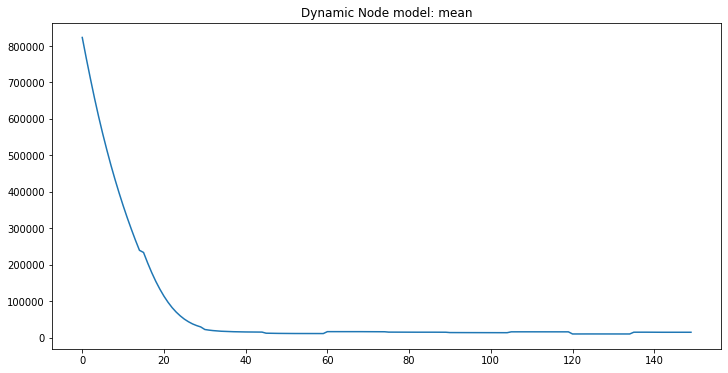

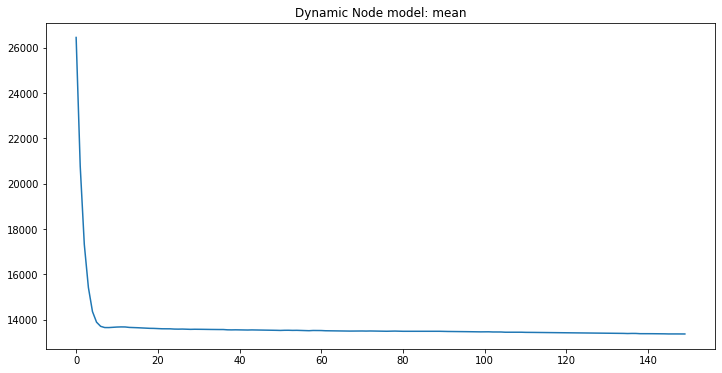

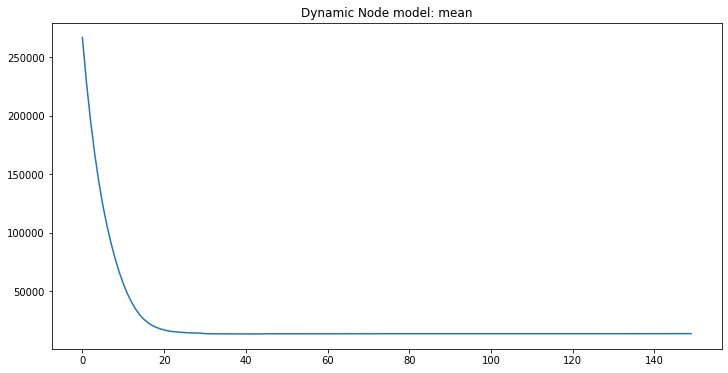

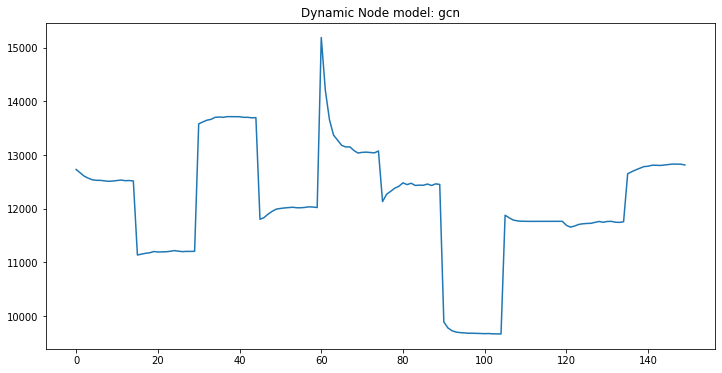

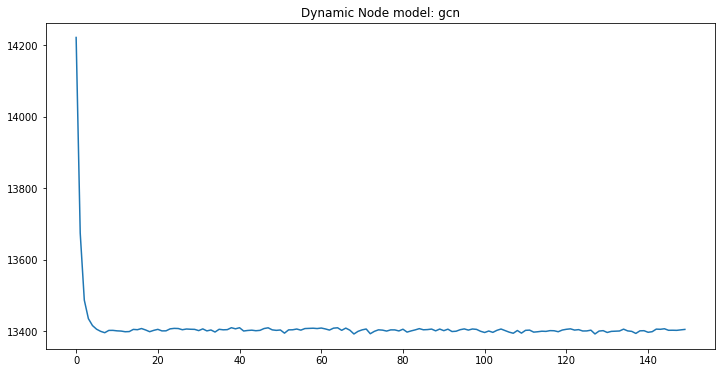

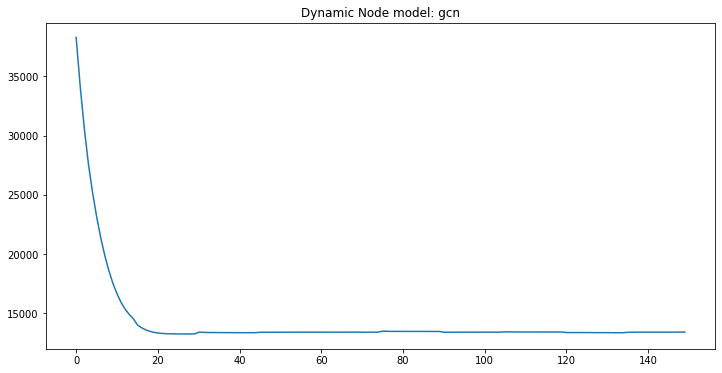

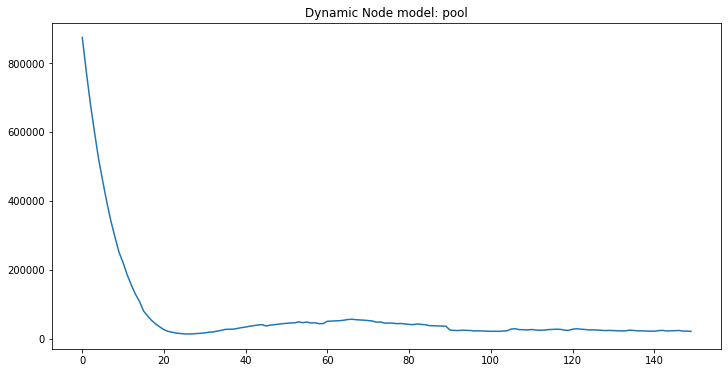

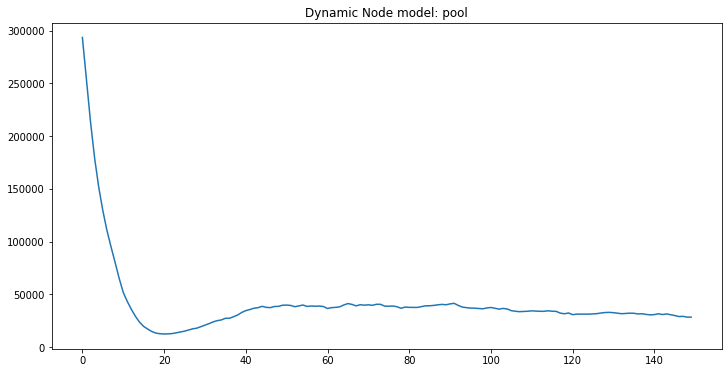

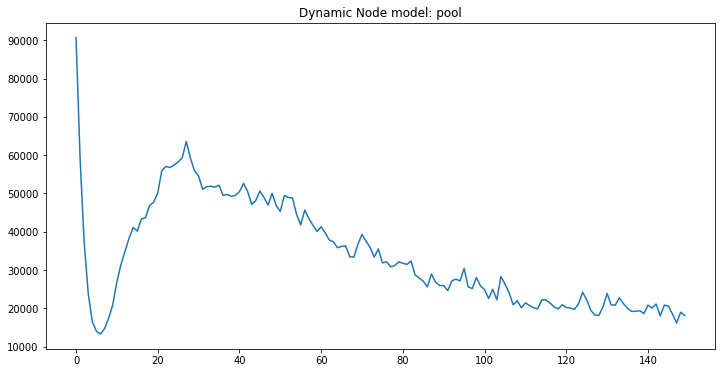

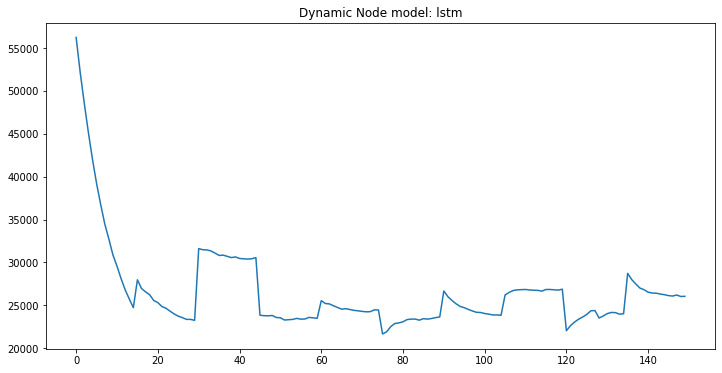

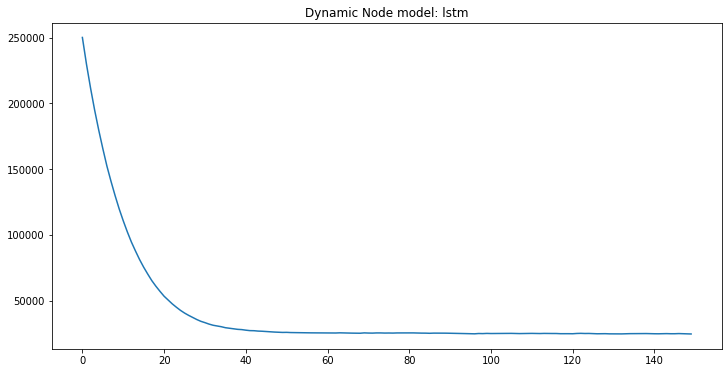

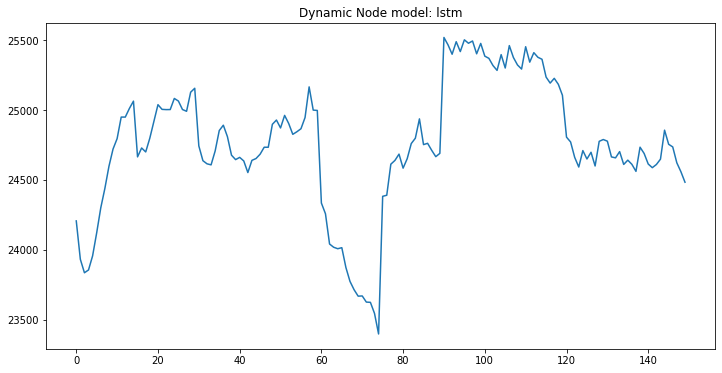

In [ ]:
# Initializing our covid_sage model with optimizer, epoch, weight_decay, learning_rate defined as below
# Create the COVID_GraphSage with the layer defined below
in_feats = 1 #input features, which is just 1 for all the nodes in temporal
n_layers = 3 #1 input, 1 hidden, 1 output
n_hidden = 10
dropout = 0.5
input_dim = 72 #past 4 historic cases for all nodes
output_dim = 18 #covid case prediction for each nodes 
# fifth value is the true value to compare, ie validation
# weight_decay = 1e-5 # 1 e-5 , 2e-5
n_epochs = 150
# lr = 2e-4 # 2 e-4  , 2.7 e-4
weight_decays = {"mean":1e-5, "gcn":2e-6, "pool":1e-5, "lstm":1e-5}
learning_rates = {"mean":2e-4, "gcn":1.9e-4, "pool":2e-4, "lstm":2e-4} # train temporal

agg_types = ["mean","gcn","pool","lstm"]
subgraph_types = ["node","edge","walk"]
temporal_dyn_model_node_models = []
for agg in agg_types:
  for subgraph_type in subgraph_types:
    losses = []
    Temporal_Dyn_node_COVID_Sage_Model = COVID_GraphSage(in_feats=in_feats, n_hidden=n_hidden, out_dim=output_dim, activation=F.relu, dropout=dropout,aggregator_type=agg)
    Temporal_dyn_model = COVID_Sage_Case(Temporal_Dyn_node_COVID_Sage_Model,n_hidden)
    optimizer = torch.optim.Adam(Temporal_dyn_model.parameters(), lr=learning_rates[agg], weight_decay=weight_decays[agg],betas=(0.85, 0.999))
    modified_val = modified_val.astype('double')
    modified_input = modified_input.astype('double')
    Temporal_dyn_model = Temporal_dyn_model.double()
    # Train our model
    print("agg type:", agg, "subgraph_type:", subgraph_type)
    TrainTemporalDynamic(Temporal_dyn_model,graph=temporal_covid_graph,features=torch.tensor(temporal_input), labels=torch.tensor(temporal_val),n_epochs=n_epochs, optimizer=optimizer, mode=subgraph_type)
    temporal_dyn_model_node_models.append(Temporal_dyn_model)
    plt.figure(figsize=(12,6))
    plt.title("Dynamic Node model: "+ str(agg))
    torch.save(Temporal_dyn_model.state_dict(),("/content/drive/MyDrive/COMP 4222/TemporalModels/" + str(subgraph_type)+ str(agg)))
    plt.plot(losses, label=agg)
    plt.savefig("/content/drive/MyDrive/COMP 4222/TemporalModels/loss_graph_"+str(subgraph_type)+"_"+str(agg)+".svg")

### **TIGHT TEMPORAL**

In [ ]:
# Initializing our covid_sage model with optimizer, epoch, weight_decay, learning_rate defined as below
# Create the COVID_GraphSage with the layer defined below
in_feats = 1 #input features, which is just 1 for all the nodes in temporal
n_layers = 3 #1 input, 1 hidden, 1 output
n_hidden = 10
dropout = 0.5
input_dim = 72 #past 4 historic cases for all nodes
output_dim = 18 #covid case prediction for each nodes 
# fifth value is the true value to compare, ie validation
# weight_decay = 1e-5 # 1 e-5 , 2e-5
n_epochs = 150
# lr = 2e-4 # 2 e-4  , 2.7 e-4
weight_decays = {"mean":1e-7, "gcn":2e-8, "pool":1e-5, "lstm":1e-5}
learning_rates = {"mean":2.2e-5, "gcn":1.6e-4, "pool":2e-4, "lstm":2e-4}
agg_types = ["mean","gcn","pool","lstm"]

subgraph_types = ["node","edge","walk"]
tight_temporal_dyn_model_node_models = []
for agg in agg_types:
  for subgraph_type in subgraph_types:
    losses = []
    Tight_Temporal_Dyn_node_COVID_Sage_Model = COVID_GraphSage(in_feats=in_feats, n_hidden=n_hidden, out_dim=output_dim, activation=F.relu, dropout=dropout,aggregator_type=agg)
    Tight_Temporal_dyn_node_model = COVID_Sage_Case(Tight_Temporal_Dyn_node_COVID_Sage_Model,n_hidden)
    optimizer = torch.optim.Adam(Tight_Temporal_dyn_node_model.parameters(), lr=learning_rates[agg], weight_decay=weight_decays[agg],betas=(0.85, 0.999))
    modified_val = modified_val.astype('double')
    modified_input = modified_input.astype('double')
    Tight_Temporal_dyn_node_model = Tight_Temporal_dyn_node_model.double()
    # Train our model
    print("agg type:", agg, "subgraph_type:", subgraph_type)
    TrainTemporalDynamic(Tight_Temporal_dyn_node_model,graph=tight_temporal_covid_graph,features=torch.tensor(temporal_input), labels=torch.tensor(temporal_val),n_epochs=n_epochs, optimizer=optimizer, mode=subgraph_type)
    tight_temporal_dyn_model_node_models.append(Tight_Temporal_dyn_node_model)
    plt.figure(figsize=(12,6))
    plt.title("Dynamic Node model: "+ str(agg))
    torch.save(Tight_Temporal_dyn_node_model.state_dict(),("/content/drive/MyDrive/COMP 4222/TightTemporalModels/" + str(subgraph_type)+ str(agg)))
    Tight_Temporal_dyn_node_model = None
    plt.plot(losses, label=agg)
    plt.savefig("/content/drive/MyDrive/COMP 4222/TightTemporalModels/loss_graph_"+str(subgraph_type)+"_"+str(agg)+".svg")

agg type: mean subgraph_type: node
Original features size is  torch.Size([53, 72])  and the original labels shape is  torch.Size([53, 72])
Epoch: 0, Loss: 480977.74354799854, SMAPE: 1.0
Epoch: 1, Loss: 477385.61832789524, SMAPE: 1.0
Epoch: 2, Loss: 473915.100526212, SMAPE: 1.0
Epoch: 3, Loss: 470496.82317349105, SMAPE: 1.0
Epoch: 4, Loss: 467136.1623923115, SMAPE: 1.0
Epoch: 5, Loss: 463815.63961083576, SMAPE: 1.0
Epoch: 6, Loss: 460502.21288735716, SMAPE: 1.0
Epoch: 7, Loss: 457237.10637096135, SMAPE: 1.0
Epoch: 8, Loss: 453984.27028443763, SMAPE: 1.0
Epoch: 9, Loss: 450714.8180092843, SMAPE: 1.0
Epoch: 10, Loss: 447500.7318241943, SMAPE: 1.0
Epoch: 11, Loss: 444309.49379928224, SMAPE: 1.0
Epoch: 12, Loss: 441132.0271628875, SMAPE: 1.0
Epoch: 13, Loss: 437956.45580526383, SMAPE: 1.0
Epoch: 14, Loss: 434803.2691279298, SMAPE: 1.0
Epoch: 0, Loss: 436007.6624152778, SMAPE: 1.0
Epoch: 1, Loss: 432683.7319222854, SMAPE: 1.0
Epoch: 2, Loss: 429393.2422933331, SMAPE: 1.0
Epoch: 3, Loss: 4261

### **DYNAMIC TIME INVARAINT**

Original features size is  torch.Size([53, 18, 4])  and the original labels shape is  torch.Size([53, 18, 1])
Epoch: 0, Loss: 2002880.5338920078, SMAPE: 1.0
Epoch: 1, Loss: 1619598.8552457155, SMAPE: 1.0
Epoch: 2, Loss: 1313145.8969807962, SMAPE: 1.0
Epoch: 3, Loss: 1069014.131388353, SMAPE: 1.0
Epoch: 4, Loss: 878819.6718996968, SMAPE: 1.0
Epoch: 5, Loss: 722740.1740381644, SMAPE: 1.0
Epoch: 6, Loss: 589469.888134168, SMAPE: 1.0
Epoch: 7, Loss: 470259.99254635104, SMAPE: 1.0
Epoch: 8, Loss: 363731.4409874212, SMAPE: 1.0
Epoch: 9, Loss: 277606.8827845501, SMAPE: 1.0
Epoch: 10, Loss: 203806.12263958555, SMAPE: 1.0
Epoch: 11, Loss: 145800.2846006453, SMAPE: 0.9921681466599469
Epoch: 12, Loss: 102419.49304408887, SMAPE: 0.7916234937593998
Epoch: 13, Loss: 70734.72746554104, SMAPE: 0.5562401869321792
Epoch: 14, Loss: 48668.30723799257, SMAPE: 0.3888767818994702
Epoch: 0, Loss: 49587.835633880735, SMAPE: 0.3131454857006152
Epoch: 1, Loss: 33811.07594370416, SMAPE: 0.226179336755541
Epoch: 2

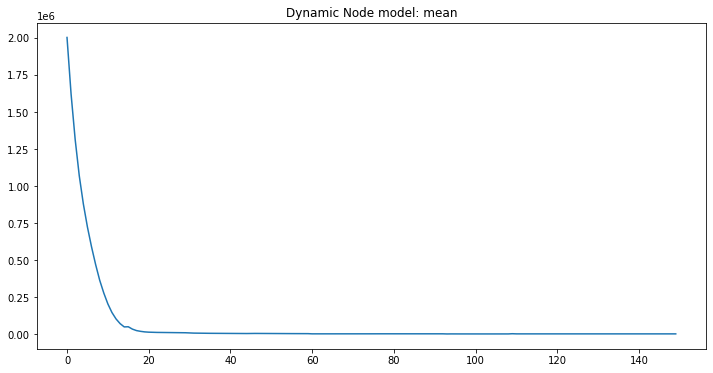

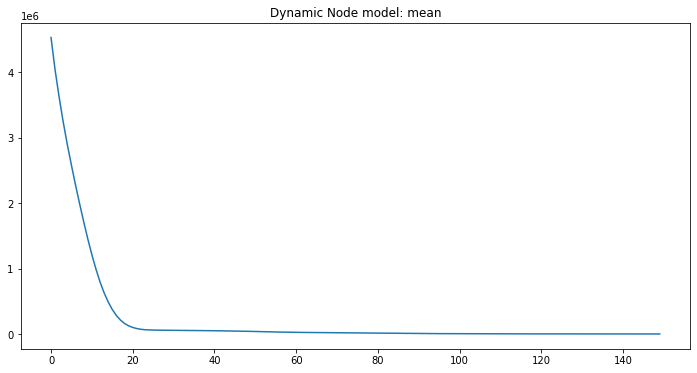

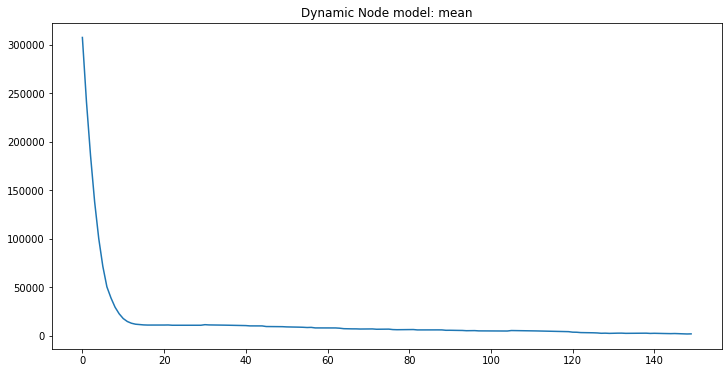

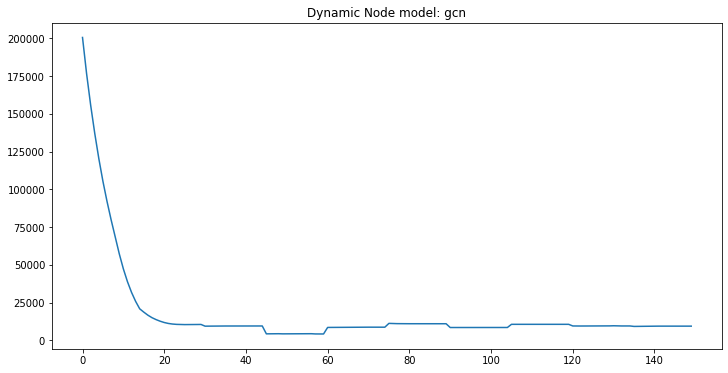

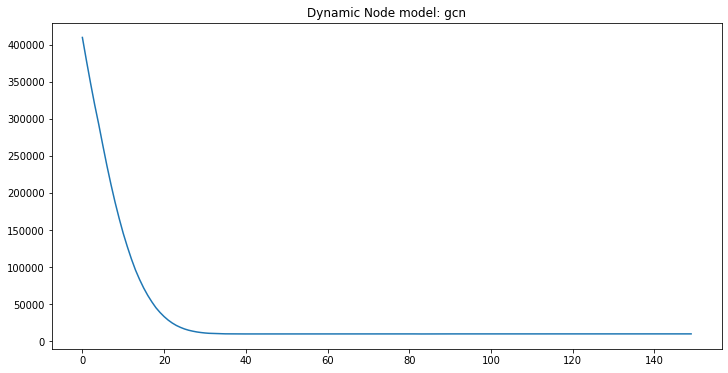

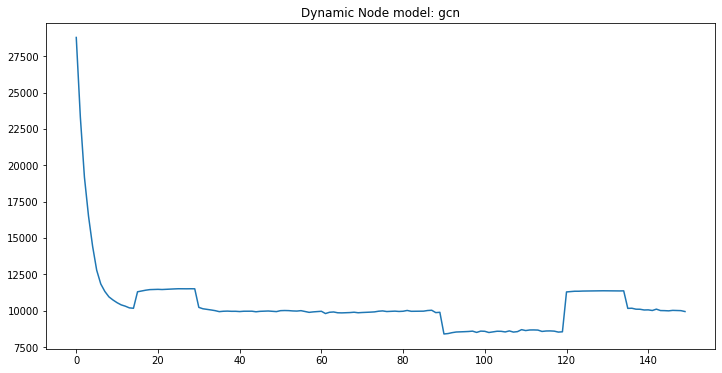

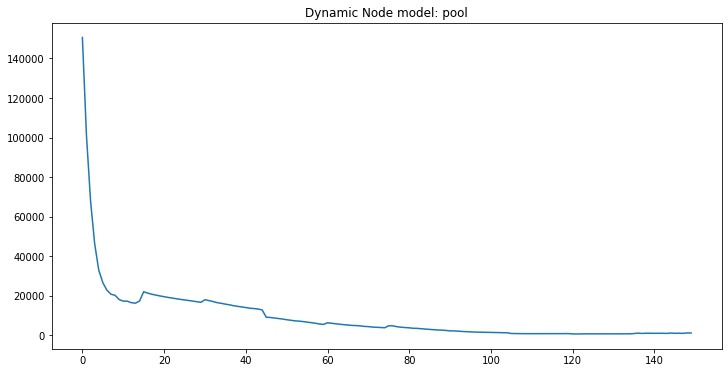

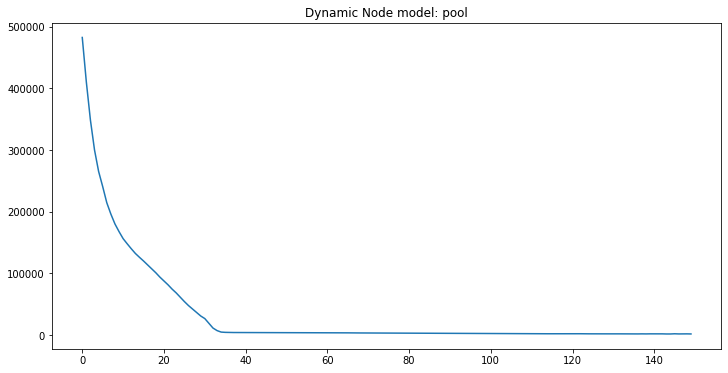

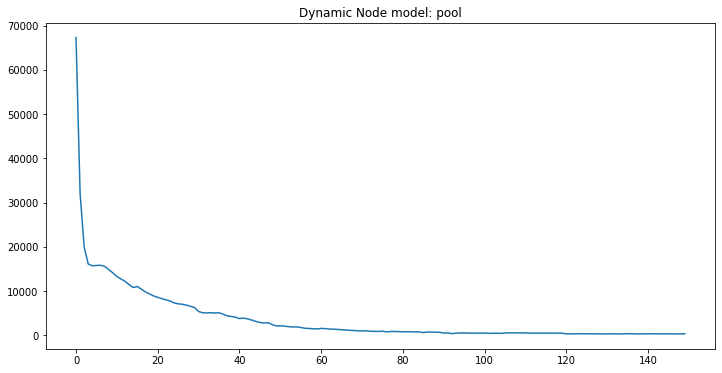

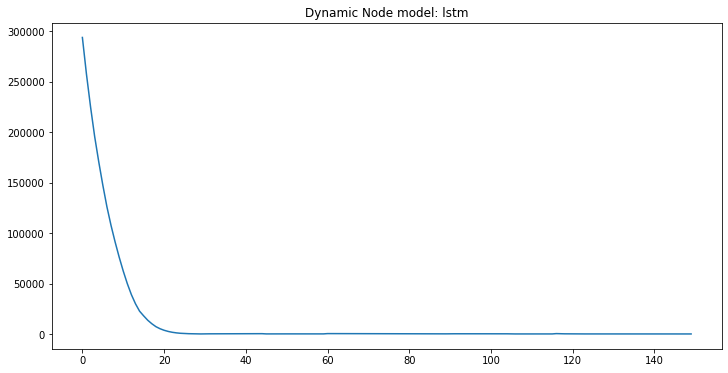

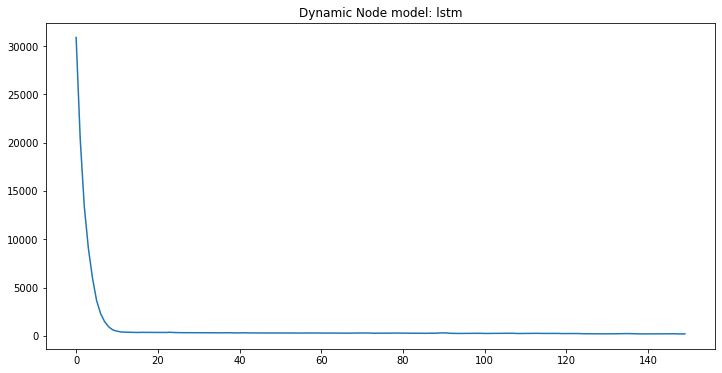

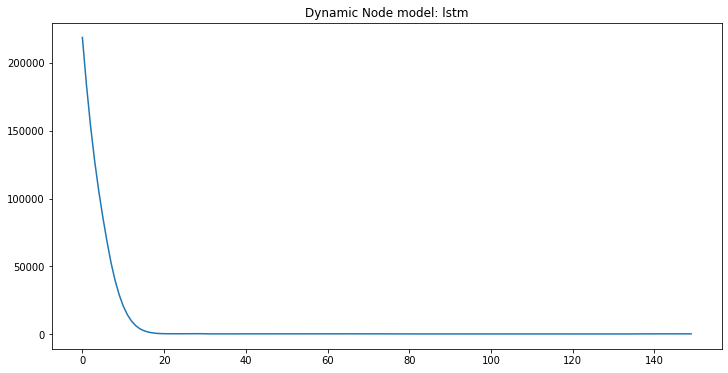

In [ ]:
# Initializing our covid_sage model with optimizer, epoch, weight_decay, learning_rate defined as below
# Create the COVID_GraphSage with the layer defined below
in_feats = 4 #input features, which is our sliding window size
n_layers = 3 #1 input, 1 hidden, 1 output
n_hidden = 10
dropout = 0.5
input_dim = (18,4) #past 4 historic cases for all nodes
output_dim = 18 #covid case prediction for each nodes 
# fifth value is the true value to compare, ie validation
# weight_decay = 1e-5 # 1 e-5 , 2e-5
n_epochs = 150
# lr = 2e-4 # 2 e-4  , 2.7 e-4
weight_decays = {"mean":1e-5, "gcn":2e-8, "pool":1e-5, "lstm":1e-5}
learning_rates = {"mean":2e-4, "gcn":1.6e-4, "pool":2e-4, "lstm":2e-4}
agg_types = ["mean","gcn","pool","lstm"]
subgraph_types = ["node","edge","walk"]
dyn_model_node_models = []
for agg in agg_types:
  for subgraph_type in subgraph_types:
    losses = []
    Dyn_COVID_Sage_Model = COVID_GraphSage(in_feats=in_feats, n_hidden=n_hidden, out_dim=output_dim, activation=F.relu, dropout=dropout,aggregator_type=agg)
    dyn_model = COVID_Sage_Case(Dyn_COVID_Sage_Model,n_hidden)
    optimizer = torch.optim.Adam(dyn_model.parameters(), lr=learning_rates[agg], weight_decay=weight_decays[agg],betas=(0.85, 0.999))
    modified_val = modified_val.astype('double')
    modified_input = modified_input.astype('double')
    dyn_model = dyn_model.double()
    # Train our model
    TrainDynamic(dyn_model,graph=covid_graph,features=torch.tensor(modified_input), labels=torch.tensor(modified_val),n_epochs=n_epochs, optimizer=optimizer, mode=subgraph_type)
    dyn_model_node_models.append(dyn_model)
    torch.save(dyn_model.state_dict(),("/content/drive/MyDrive/COMP 4222/DynamicTimeInvariant/" + str(subgraph_type) + str(agg)))
    plt.figure(figsize=(12,6))
    plt.title("Dynamic Node model: "+ str(agg))
    plt.plot(losses, label=agg)
    plt.savefig("/content/drive/MyDrive/COMP 4222/DynamicTimeInvariant/loss_graph_"+str(subgraph_type)+"_"+str(agg)+".svg")

### **STATIC TIME INVARIANT**

In [ ]:
# Initializing our covid_sage model with optimizer, epoch, weight_decay, learning_rate defined as below
in_feats = 4 #input features, which is our sliding window size
n_layers = 3 #1 input, 1 hidden, 1 output
n_hidden = 10
dropout = 0.5
input_dim = (18,4) #past 4 historic cases for all nodes
output_dim = 18 #covid case prediction for each nodes 
weight_decay = 1e-5 # 1 e-5 , 2e-5
n_epochs = 150
lr = 2e-4 # 2 e-4  , 2.7 e-4
agg_types = ["mean","gcn","pool","lstm"]
weight_decays = {"mean":1e-5, "gcn":2e-8, "pool":1e-5, "lstm":1e-5}
learning_rates = {"mean":2e-4, "gcn":1.6e-4, "pool":2e-4, "lstm":2e-4}
stat_models = []
for agg in agg_types:
    losses =[]
    COVID_Sage_Model = COVID_GraphSage(in_feats=in_feats, n_hidden=n_hidden, out_dim=output_dim, activation=F.relu, dropout=dropout, aggregator_type=agg)
    model = COVID_Sage_Case(COVID_Sage_Model,n_hidden)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rates[agg], weight_decay=weight_decays[agg],betas=(0.85, 0.999))
    modified_val = modified_val.astype('double')
    modified_input = modified_input.astype('double')
    model = model.double()
    # Train our model
    Train(model,graph=covid_graph,features=torch.tensor(modified_input), labels=torch.tensor(modified_val),n_epochs=n_epochs, optimizer=optimizer)
    torch.save(model.state_dict(),("/content/drive/MyDrive/COMP 4222/StaticTimeInvariant/" + str(agg)))
    stat_models.append(model)
    plt.figure(figsize=(12,6))
    plt.title("Static model: "+ str(agg))
    plt.plot(losses[2:-1])
    plt.savefig("/content/drive/MyDrive/COMP 4222/StaticTimeInvariant/" + "loss_graph_"+str(agg)+".svg")

In [ ]:
# # Initializing our covid_sage model with optimizer, epoch, weight_decay, learning_rate defined as below
# weight_decay = 2e-6 # 1 e-5 , 2e-5
# n_epochs = 150
# lr = 2.5e-5 # 2 e-4  , 2.7 e-4
# model = COVID_Sage_Case(COVID_Sage_Model,n_hidden)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay,betas=(0.85, 0.999))
# modified_val = modified_val.astype('double')
# modified_input = modified_input.astype('double')
# model = model.double()

# # Train our model
# Train(model,graph=covid_graph,features=torch.tensor(modified_input), labels=torch.tensor(modified_val),n_epochs=n_epochs, optimizer=optimizer)
# plt.plot(losses[2:-1])

## Testing our model with data from Apr 1st - May 31st

In [67]:
import pandas as pd
test_csv_pds = []
test_dates = []
for file in os.listdir("/content/drive/MyDrive/COMP 4222/data_Apr1_May31"):
    if file.endswith(".csv"):
        test_csv_pds.append(pd.read_csv("/content/drive/MyDrive/COMP 4222/data_Apr1_May31/"+file,on_bad_lines="skip"))
        test_dates.append(file[0:8])

# import pandas as pd
# test_csv_pds = []
# test_dates = []
# for file in os.listdir("/content/drive/MyDrive/COMP 4222/data_Nov7_Nov13"):
#     if file.endswith(".csv"):
#         test_csv_pds.append(pd.read_csv("/content/drive/MyDrive/COMP 4222/data_Nov7_Nov13/"+file,on_bad_lines="skip"))
#         test_dates.append(file[0:8])

In [68]:
from difflib import SequenceMatcher
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

districts = ['Central & Western', 'Eastern', 'Islands', 'Kowloon City', 'Kwai Tsing',
 'Kwun Tong', 'North', 'Sai Kung', 'Sham Shui Po', 'Sha Tin', 'Southern',
 'Tai Po', 'Tsuen Wan', 'Tuen Mun', 'Wan Chai', 'Wong Tai Sin', 'Yau Tsim Mong',
 'Yuen Long']

iter =0
for csv in test_csv_pds:
  csv["District"] = csv.apply(lambda row: districts[np.argmax(np.array([similar(row["District"],key) for key in districts]))], axis=1)
  count = csv['District'].unique()
  if len(count) != 18:
    print("failed entry recorded") 
  print(iter, end = " ")
  iter +=1

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 

In [69]:
test_series_count_district ={}
for district in districts:
    test_series_count_district[district] = []

In [70]:
for pd in test_csv_pds:
    for district in districts:
          test_series_count_district[district].append((pd['District'] == district).sum())

In [71]:
test_district_series = []
for district in districts:
  test_district_series.append(test_series_count_district[district])

In [72]:
window_size = 4 # hyper parameter
test_modified_input = []
test_modified_val = []
for sequence in test_district_series:
    input_sequence = [sequence[i:i+window_size] for i in range(0,len(sequence)-4)]
    val_sequence = [[sequence[i+window_size] for i in range(0,len(sequence)-4)]]
    test_modified_input.append(input_sequence)
    test_modified_val.append(np.array(val_sequence))

test_modified_input = np.array(test_modified_input)
test_modified_val=  np.array(test_modified_val)
test_modified_val = test_modified_val.reshape(18,-1,1)
test_modified_input =np.array([test_modified_input[:,x,:] for x in range(len(sequence)-4)])
test_modified_val = np.array([test_modified_val[:,x,:] for x in range(len(sequence)-4)])
test_temporal_input = test_modified_input.reshape(test_modified_input.shape[0],-1)
test_temporal_val = np.squeeze(np.concatenate((np.expand_dims(test_modified_input[:,:,-3], axis=2),np.expand_dims(test_modified_input[:,:,-2], axis=2),np.expand_dims(test_modified_input[:,:,-1], axis=2),test_modified_val),axis=1))

## **TESTING STATIC TIMEINVARIANT**

In [27]:
# load static models
agg_types = ["mean","gcn","pool","lstm"]
n_hidden = 10
stats_model = []
for agg in agg_types:
  agg_graph = [COVID_GraphSage(in_feats=in_feats, n_hidden=n_hidden, out_dim=output_dim, activation=F.relu, dropout=dropout, aggregator_type=agg) for agg in agg_types]
  COVID_Sage_Model = COVID_GraphSage(in_feats=in_feats, n_hidden=n_hidden, out_dim=output_dim, activation=F.relu, dropout=dropout, aggregator_type=agg)
  model = COVID_Sage_Case(COVID_Sage_Model,n_hidden)
  model = model.double()

  stats_model.append(model) 
for i in range(len(agg_types)):
  stats_model[i].load_state_dict(torch.load("/content/drive/MyDrive/COMP 4222/StaticTimeInvariant/" + str(agg_types[i])))

In [ ]:
static_result = {x: [] for x in agg_types}
static_forecast = {x: [] for x in agg_types} 
for i in range(4):
  model = stats_model[i]
  agg = agg_types[i]
  results = []
  forecasts = []
  for i in range(test_modified_input.shape[0]):
    result, forecast = Test(model,graph=covid_graph,features=torch.tensor(test_modified_input[i], dtype=float),labels=torch.tensor(test_modified_val[i], dtype=float))
    results.append(result)
    forecasts.append(forecast)
  forecasts = np.array(forecasts)
  static_result[agg] = results
  static_forecast[agg] = forecasts

Testing SMAPE: 0.06127877662253126
Testing SMAPE: 0.0599941613985385
Testing SMAPE: 0.06484292343828306
Testing SMAPE: 0.07780064485384111
Testing SMAPE: 0.07026103155512772
Testing SMAPE: 0.08053105394194286
Testing SMAPE: 0.07829618315573557
Testing SMAPE: 0.082343414384962
Testing SMAPE: 0.0688566613524463
Testing SMAPE: 0.07222442550417273
Testing SMAPE: 0.09344143315479161
Testing SMAPE: 0.08530877890309155
Testing SMAPE: 0.08885387580079919
Testing SMAPE: 0.07219609322278406
Testing SMAPE: 0.09357606085703478
Testing SMAPE: 0.11724474780677942
Testing SMAPE: 0.07420119771285655
Testing SMAPE: 0.08038378575451177
Testing SMAPE: 0.1255572934271722
Testing SMAPE: 0.08292052131073818
Testing SMAPE: 0.12789762758770676
Testing SMAPE: 0.10560817056526071
Testing SMAPE: 0.08541678381220003
Testing SMAPE: 0.0875366451506227
Testing SMAPE: 0.0886503854528346
Testing SMAPE: 0.08419042989037283
Testing SMAPE: 0.10703811571524016
Testing SMAPE: 0.0877551409849876
Testing SMAPE: 0.11426234953

Errors in test for static time invariant for mean
mean: 0.08631445329618834
std: 0.014901267010778926

Errors in test for static time invariant for gcn
mean: 0.14334909594956657
std: 0.01876571224520464

Errors in test for static time invariant for pool
mean: 0.038880537006008936
std: 0.014889792794666894

Errors in test for static time invariant for lstm
mean: 0.041152467587346774
std: 0.025536131557443477



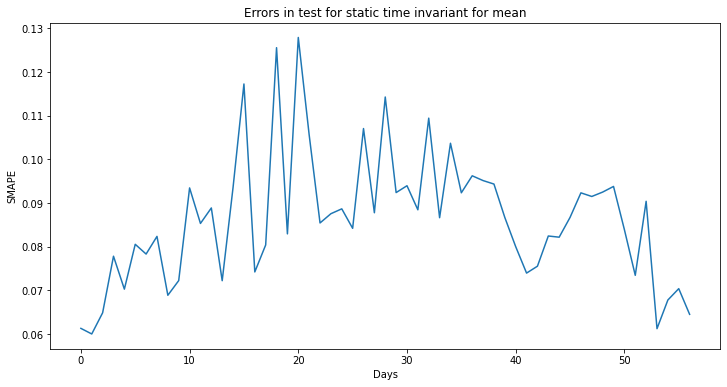

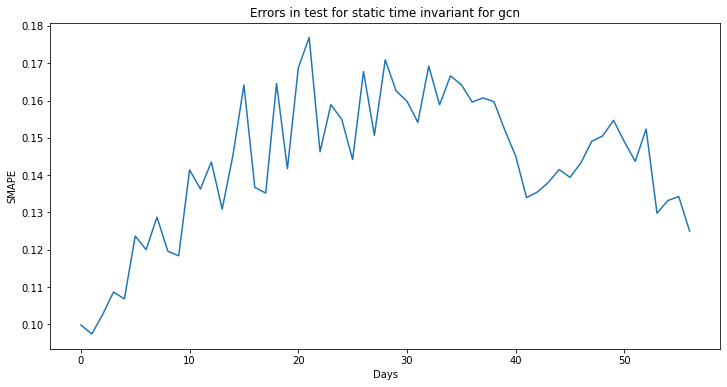

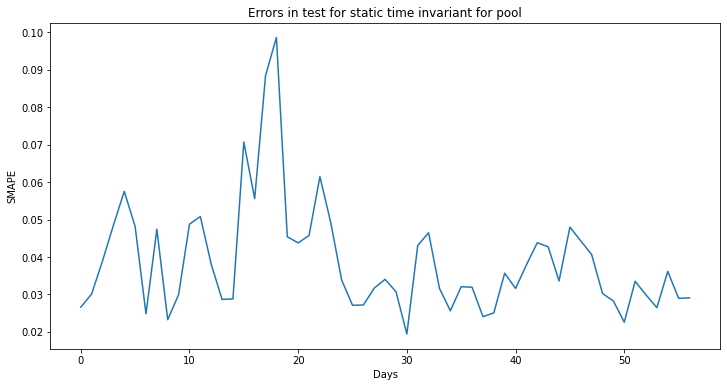

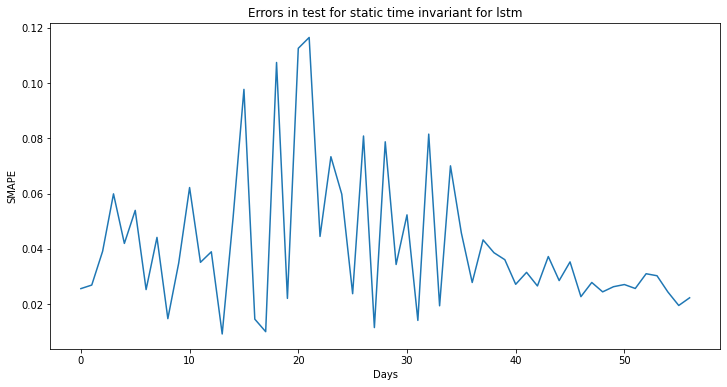

In [ ]:
# RESULT PLOTTING AND COMPARISONS
for agg_type, results in static_result.items():
    plt.figure(figsize=(12,6))
    plt.title("Errors in test for static time invariant" + f" for {agg_type}")
    plt.xlabel("Days")
    plt.ylabel("SMAPE")
    plt.plot(results)
    print("Errors in test for static time invariant" + f" for {agg_type}")
    print("mean:",sum(results)/len(results))
    results = np.array(results)
    print("std:", np.std(results))
    print()

## **TESTING DYNAMIC TIMEINVARIANT**

In [73]:
# load dynamic models
agg_types = ["mean","gcn","pool","lstm"]
subgraph_types = ["node","edge","walk"]
n_hidden = 10
COVID_Sage_Case(COVID_Sage_Model,n_hidden)
dynamic_models = {x: [] for x in subgraph_types}
for agg in agg_types:
  for subgraph_type in subgraph_types:
    agg_graph = [COVID_GraphSage(in_feats=in_feats, n_hidden=n_hidden, out_dim=output_dim, activation=F.relu, dropout=dropout, aggregator_type=agg) for agg in agg_types]
    COVID_Sage_Model = COVID_GraphSage(in_feats=in_feats, n_hidden=n_hidden, out_dim=output_dim, activation=F.relu, dropout=dropout, aggregator_type=agg)
    model = COVID_Sage_Case(COVID_Sage_Model,n_hidden)
    model = model.double()
    dynamic_models[subgraph_type].append(model) 
for subgraph_type in subgraph_types:
  for i in range(len(agg_types)):
    dynamic_models[subgraph_type][i].load_state_dict(torch.load("/content/drive/MyDrive/COMP 4222/DynamicTimeInvariant/" + subgraph_type + str(agg_types[i])))

RuntimeError: ignored

In [ ]:
dynamic_all_result = {x: [] for x in subgraph_types}
dynamic_all_forecast = {x: [] for x in subgraph_types}

for subgraph_type in subgraph_types:
  dynamic_result = {x: [] for x in agg_types}
  dynamic_forecast = {x: [] for x in agg_types}
  dynamic_model = dynamic_models[subgraph_type]
  for i in range(4):
    model = dynamic_model[i]
    agg = agg_types[i]
    results = []
    forecasts = []
    for i in range(test_modified_input.shape[0]):
      result, forecast = Test(model,graph=covid_graph,features=torch.tensor(test_modified_input[i], dtype=float),labels=torch.tensor(test_modified_val[i], dtype=float))
      results.append(result)
      forecasts.append(forecast)
    forecasts = np.array(forecasts)
    dynamic_result[agg] = results
    dynamic_forecast[agg] = forecasts
  dynamic_all_result[subgraph_type] = (dynamic_result)
  dynamic_all_forecast[subgraph_type] = (dynamic_forecast)

Testing SMAPE: 0.04681530395309868
Testing SMAPE: 0.04702253862564595
Testing SMAPE: 0.055999692233876845
Testing SMAPE: 0.07177222762076552
Testing SMAPE: 0.06388792977804546
Testing SMAPE: 0.06003708061311809
Testing SMAPE: 0.054504476910796344
Testing SMAPE: 0.05686290621788136
Testing SMAPE: 0.0362822282186871
Testing SMAPE: 0.04761146093308313
Testing SMAPE: 0.08056594952989264
Testing SMAPE: 0.05582438200631344
Testing SMAPE: 0.05343558955946862
Testing SMAPE: 0.03948843200289449
Testing SMAPE: 0.06692993341766351
Testing SMAPE: 0.119861284066125
Testing SMAPE: 0.03426224362381071
Testing SMAPE: 0.059651460837576636
Testing SMAPE: 0.11270192451481369
Testing SMAPE: 0.06767108361225894
Testing SMAPE: 0.06636799593632466
Testing SMAPE: 0.09548554035198145
Testing SMAPE: 0.04255101381827385
Testing SMAPE: 0.04925442376945446
Testing SMAPE: 0.0663177862524745
Testing SMAPE: 0.04304098858950576
Testing SMAPE: 0.06796958813236205
Testing SMAPE: 0.03338908657580762
Testing SMAPE: 0.0603

Errors in test for dynamic time invariant for mean and node subgraph sampling method
mean: 0.05414445295100192
std: 0.017250192291946752

Errors in test for dynamic time invariant for gcn and node subgraph sampling method
mean: 0.14220237263262545
std: 0.018089535342720443

Errors in test for dynamic time invariant for pool and node subgraph sampling method
mean: 0.05683224839778839
std: 0.02208940947748843

Errors in test for dynamic time invariant for lstm and node subgraph sampling method
mean: 0.03500803042808068
std: 0.022855990307558912

Errors in test for dynamic time invariant for mean and edge subgraph sampling method
mean: 0.05629329836128035
std: 0.021135043901083173

Errors in test for dynamic time invariant for gcn and edge subgraph sampling method
mean: 0.15154175186493113
std: 0.020678364895968807

Errors in test for dynamic time invariant for pool and edge subgraph sampling method
mean: 0.08232639736682008
std: 0.01960108123215404

Errors in test for dynamic time invari

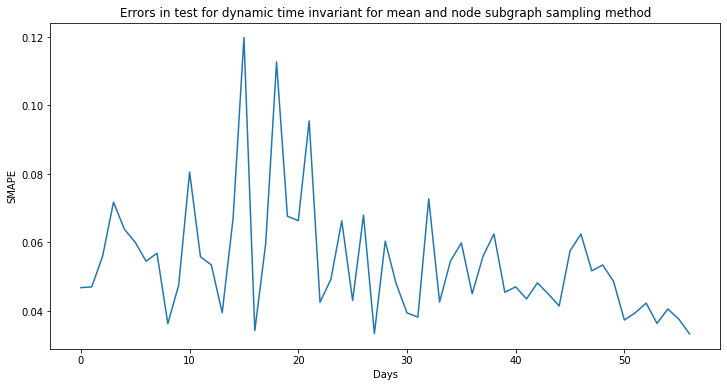

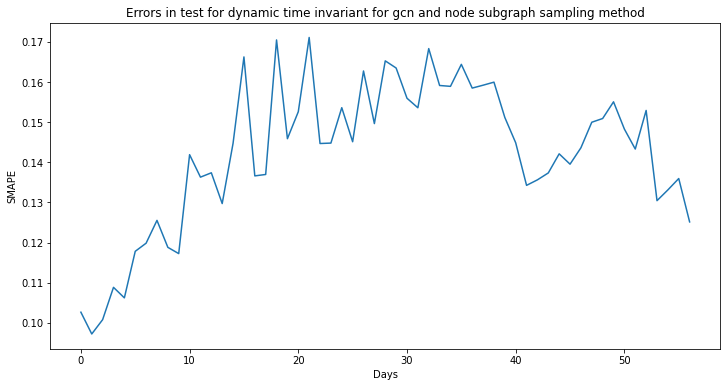

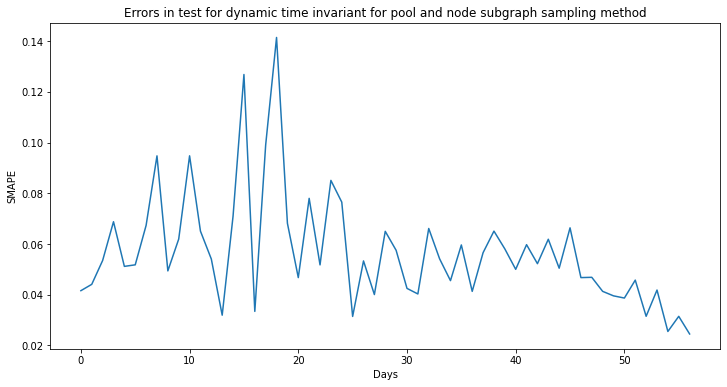

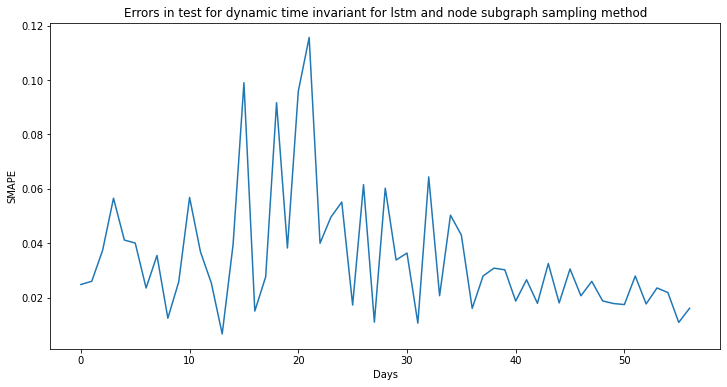

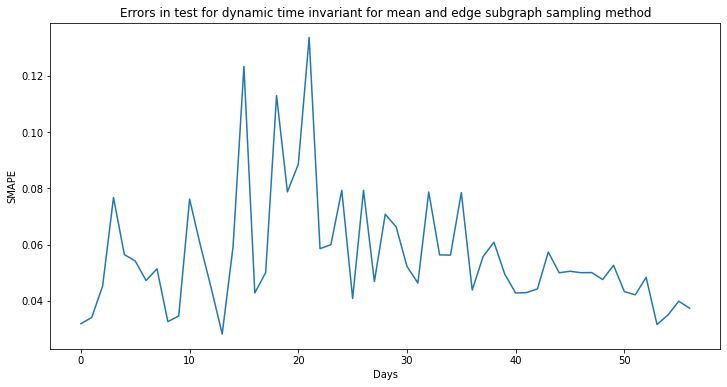

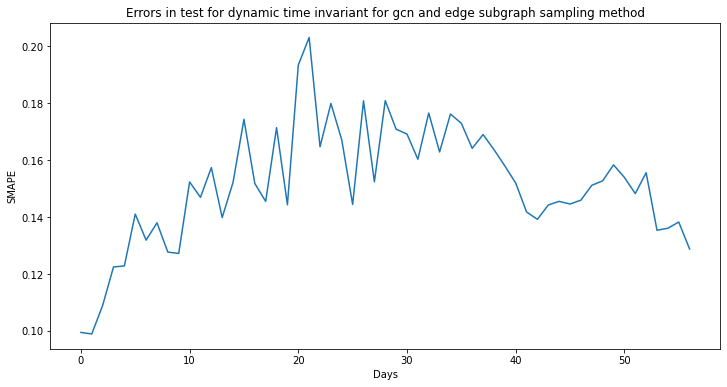

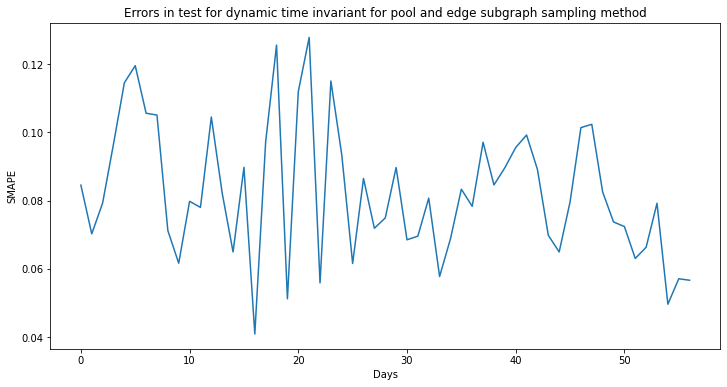

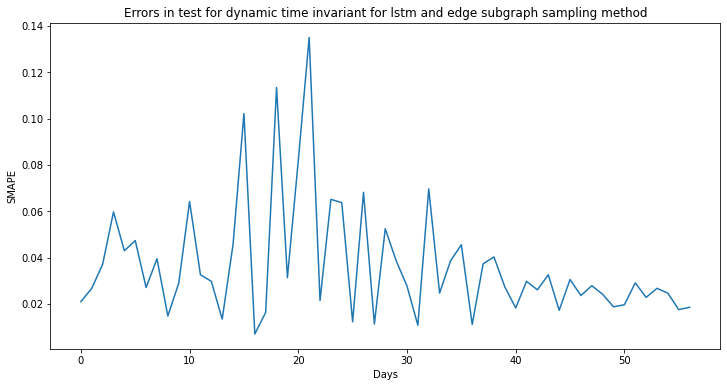

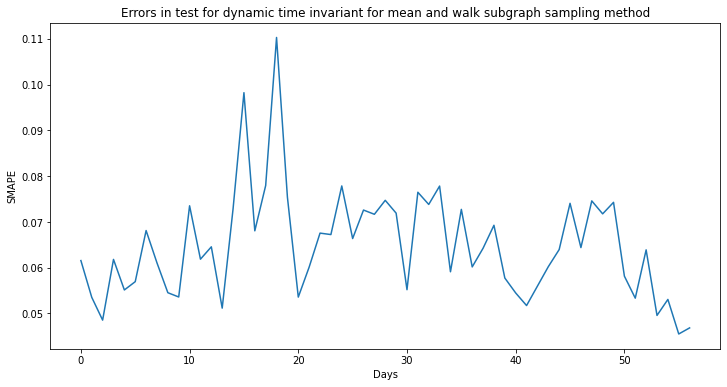

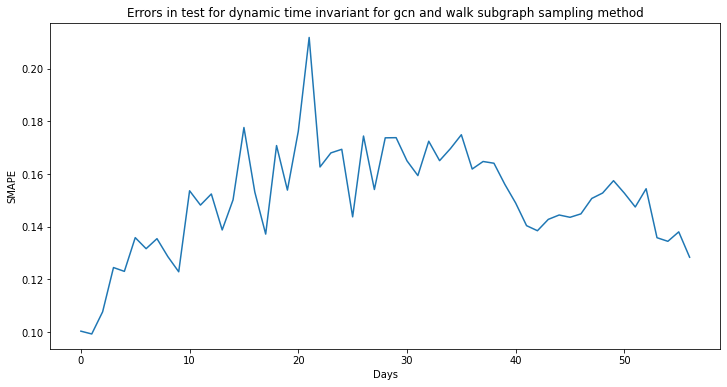

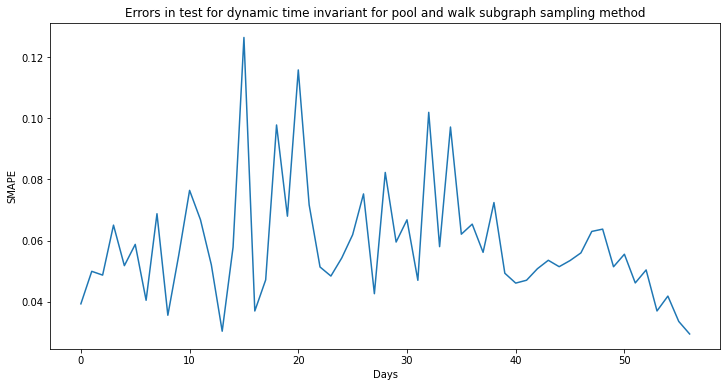

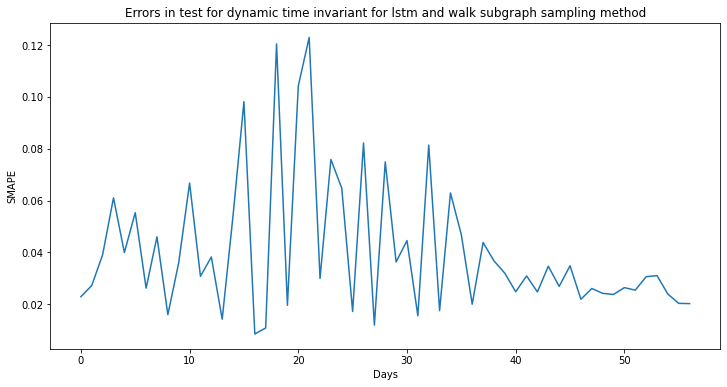

In [ ]:
# RESULT PLOTTING AND COMPARISONS
for subgraph_type in subgraph_types:
  dynamic_result = dynamic_all_result[subgraph_type]
  for agg_type, results in dynamic_result.items():
      plt.figure(figsize=(12,6))
      plt.title("Errors in test for dynamic time invariant" + f" for {agg_type} and " + f"{subgraph_type} subgraph sampling method")
      plt.xlabel("Days")
      plt.ylabel("SMAPE")
      plt.plot(results)
      print("Errors in test for dynamic time invariant" + f" for {agg_type} and " + f"{subgraph_type} subgraph sampling method")
      print("mean:",sum(results)/len(results))
      results = np.array(results)
      print("std:", np.std(results))
      print()

## **TESTING Temporal graph**

In [65]:
# load dynamic models
in_feats = 1 #input features, which is just 1 for all the nodes in temporal
n_layers = 3 #1 input, 1 hidden, 1 output
n_hidden = 10
dropout = 0.5
input_dim = 72 #past 4 historic cases for all nodes
output_dim = 18 #covid case prediction for each nodes 
# fifth value is the true value to compare, ie validation
# weight_decay = 1e-5 # 1 e-5 , 2e-5
n_epochs = 150
agg_types = ["mean","gcn","pool","lstm"]
subgraph_types = ["node","edge","walk"]
n_hidden = 10
COVID_Sage_Case(COVID_Sage_Model,n_hidden)
temporal_dyn_model_node_models = {x: [] for x in subgraph_types}
for agg in agg_types:
  for subgraph_type in subgraph_types:
    agg_graph = [COVID_GraphSage(in_feats=in_feats, n_hidden=n_hidden, out_dim=output_dim, activation=F.relu, dropout=dropout, aggregator_type=agg) for agg in agg_types]
    Temporal_Dyn_node_COVID_Sage_Model = COVID_GraphSage(in_feats=in_feats, n_hidden=n_hidden, out_dim=output_dim, activation=F.relu, dropout=dropout, aggregator_type=agg)
    Temporal_dyn_model  = COVID_Sage_Case(Temporal_Dyn_node_COVID_Sage_Model,n_hidden)
    Temporal_dyn_model  = Temporal_dyn_model .double()
    temporal_dyn_model_node_models[subgraph_type].append(Temporal_dyn_model)
for subgraph_type in subgraph_types:
  for i in range(len(agg_types)):
    temporal_dyn_model_node_models[subgraph_type][i].load_state_dict(torch.load("/content/drive/MyDrive/COMP 4222/TemporalModels/" + subgraph_type + str(agg_types[i])))

In [74]:
temporal_all_result = {x: [] for x in subgraph_types}
temporal_all_forecast = {x: [] for x in subgraph_types}

for subgraph_type in subgraph_types:
  temporal_result = {x: [] for x in agg_types}
  temporal_forecast = {x: [] for x in agg_types}
  temporal_model = temporal_dyn_model_node_models[subgraph_type]
  for i in range(4):
    model = temporal_model[i]
    agg = agg_types[i]
    results = []
    forecasts = []
    for i in range(test_modified_input.shape[0]):
      result, forecast = Test(model,graph=temporal_covid_graph,features=torch.tensor(test_temporal_input[i], dtype=float),labels=torch.tensor(test_temporal_val[i], dtype=float), isTemporal=True)
      results.append(result)
      forecasts.append(forecast)
    forecasts = np.array(forecasts)
    temporal_result[agg] = results
    temporal_forecast[agg] = forecasts
  temporal_all_result[subgraph_type] = (temporal_result)
  temporal_all_forecast[subgraph_type] = (temporal_forecast)

Testing SMAPE: 0.11969195021422363
Testing SMAPE: 0.1282968812693486
Testing SMAPE: 0.1299867955117209
Testing SMAPE: 0.1238074758446093
Testing SMAPE: 0.12093595701359439
Testing SMAPE: 0.1345622728330757
Testing SMAPE: 0.13829823865072985
Testing SMAPE: 0.13506913998103645
Testing SMAPE: 0.13294266836060692
Testing SMAPE: 0.12796472948659646
Testing SMAPE: 0.1480834990136392
Testing SMAPE: 0.1512693712296517
Testing SMAPE: 0.15494528968095936
Testing SMAPE: 0.14253065508352142
Testing SMAPE: 0.15005268713737124
Testing SMAPE: 0.16979187444196006
Testing SMAPE: 0.15632672177566692
Testing SMAPE: 0.1462752080951319
Testing SMAPE: 0.1655082153404124
Testing SMAPE: 0.15993625487703927
Testing SMAPE: 0.17082676871562014
Testing SMAPE: 0.195697448458804
Testing SMAPE: 0.16112525915672524
Testing SMAPE: 0.15997972726568926
Testing SMAPE: 0.15946896947508812
Testing SMAPE: 0.15264447274630136
Testing SMAPE: 0.16503798931984331
Testing SMAPE: 0.16176140217100154
Testing SMAPE: 0.1642044157304

Errors in test for temporal time invariant for mean and node subgraph sampling method
mean: 0.15745517182500288
std: 0.01651334850148897

Errors in test for temporal time invariant for gcn and node subgraph sampling method
mean: 0.1542337541319412
std: 0.016145315576114427

Errors in test for temporal time invariant for pool and node subgraph sampling method
mean: 0.16529566046149408
std: 0.014634693041607296

Errors in test for temporal time invariant for lstm and node subgraph sampling method
mean: 0.2149215149002099
std: 0.019622596766219462

Errors in test for temporal time invariant for mean and edge subgraph sampling method
mean: 0.15772704762980455
std: 0.016575907194252195

Errors in test for temporal time invariant for gcn and edge subgraph sampling method
mean: 0.15707145316116355
std: 0.016243492781892216

Errors in test for temporal time invariant for pool and edge subgraph sampling method
mean: 0.22475269531349246
std: 0.02115636391499502

Errors in test for temporal time 

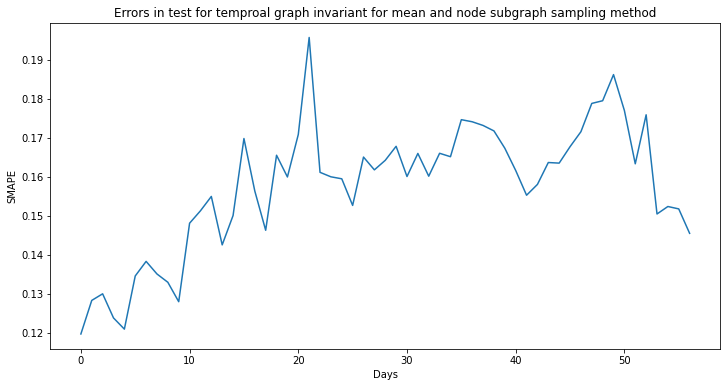

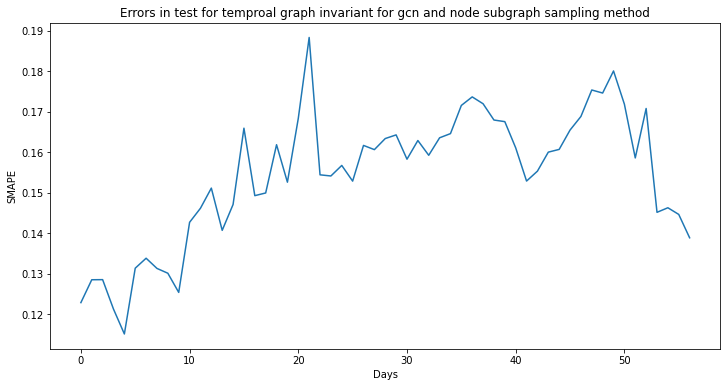

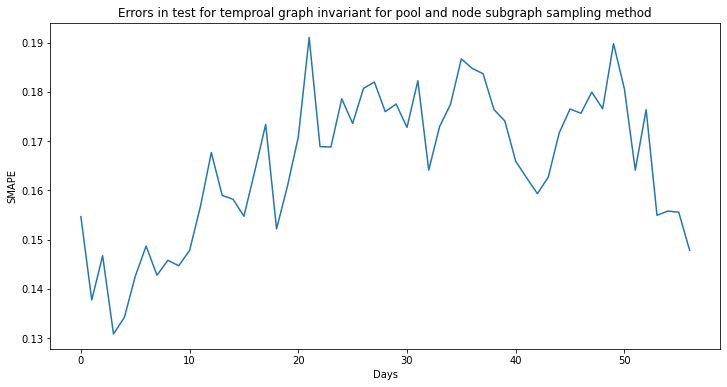

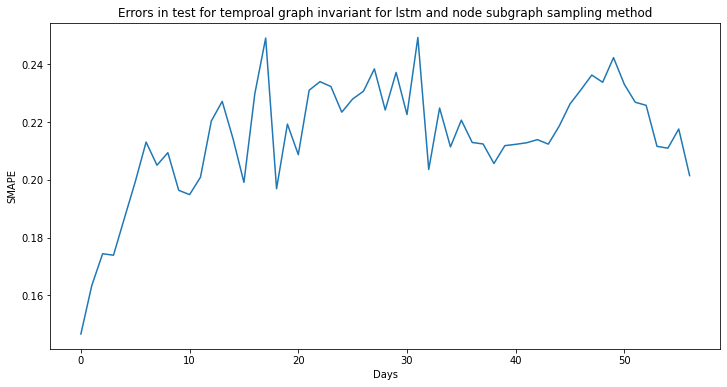

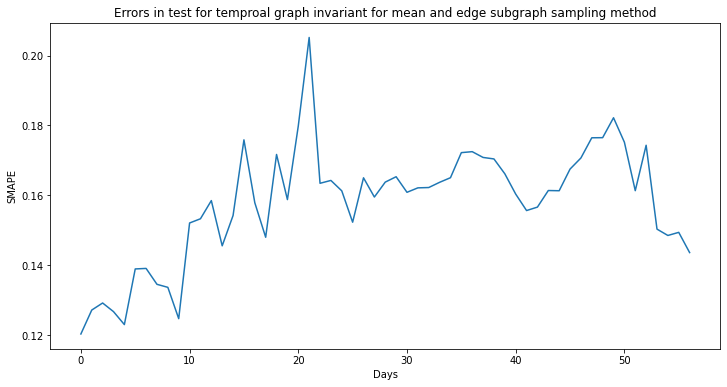

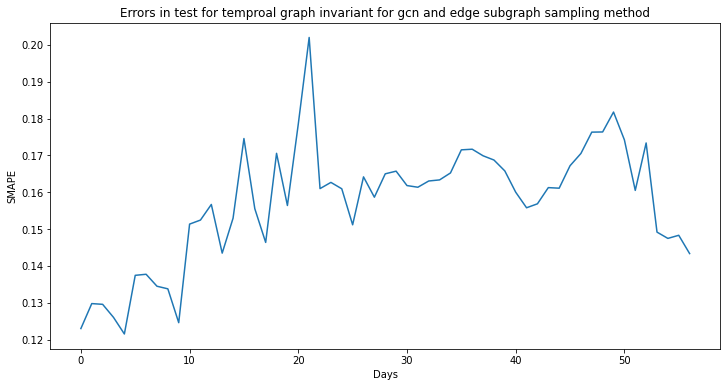

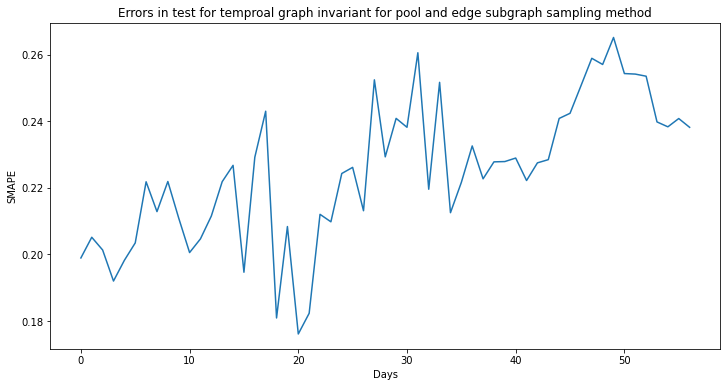

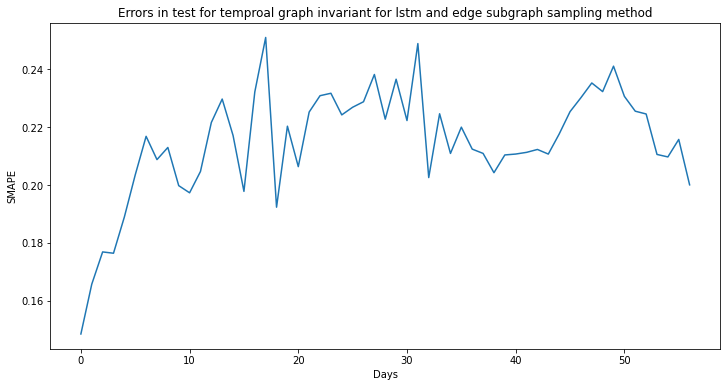

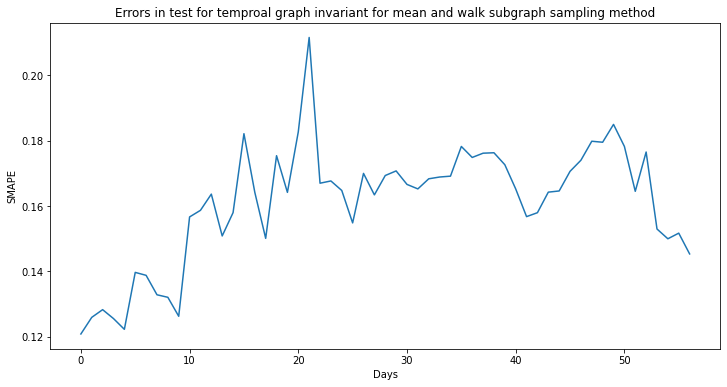

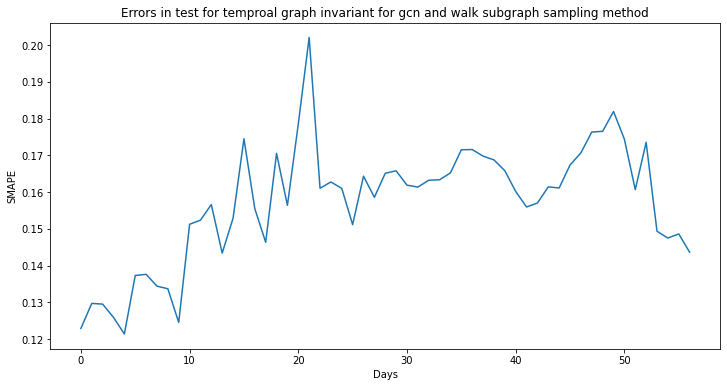

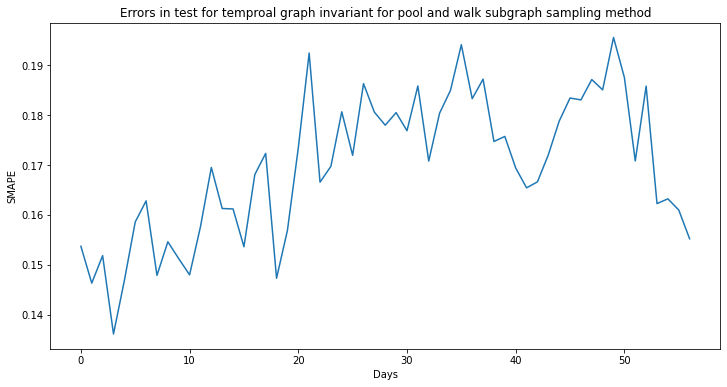

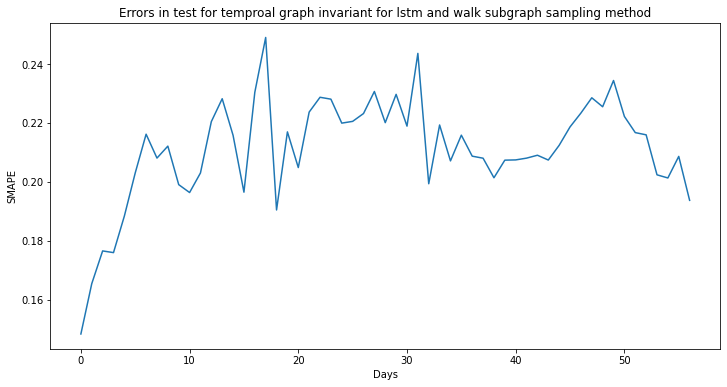

In [75]:
# RESULT PLOTTING AND COMPARISONS
for subgraph_type in subgraph_types:
  temporal_result = temporal_all_result[subgraph_type]
  for agg_type, results in temporal_result.items():
      plt.figure(figsize=(12,6))
      plt.title("Errors in test for temproal graph invariant" + f" for {agg_type} and " + f"{subgraph_type} subgraph sampling method")
      plt.xlabel("Days")
      plt.ylabel("SMAPE")
      plt.plot(results)
      print("Errors in test for temporal time invariant" + f" for {agg_type} and " + f"{subgraph_type} subgraph sampling method")
      print("mean:",sum(results)/len(results))
      results = np.array(results)
      print("std:", np.std(results))
      print()

## **TESTING Tight Temporal graph**

In [30]:
# load dynamic models
in_feats = 1 #input features, which is just 1 for all the nodes in temporal
n_layers = 3 #1 input, 1 hidden, 1 output
n_hidden = 10
dropout = 0.5
input_dim = 72 #past 4 historic cases for all nodes
output_dim = 18 #covid case prediction for each nodes 
# fifth value is the true value to compare, ie validation
# weight_decay = 1e-5 # 1 e-5 , 2e-5
n_epochs = 150
agg_types = ["mean","gcn","pool","lstm"]
subgraph_types = ["node","edge","walk"]
n_hidden = 10
COVID_Sage_Case(COVID_Sage_Model,n_hidden)
temporal_tight_dyn_model_node_models = {x: [] for x in subgraph_types}
for agg in agg_types:
  for subgraph_type in subgraph_types:
    agg_graph = [COVID_GraphSage(in_feats=in_feats, n_hidden=n_hidden, out_dim=output_dim, activation=F.relu, dropout=dropout, aggregator_type=agg) for agg in agg_types]
    Temporal_Dyn_node_COVID_Sage_Model = COVID_GraphSage(in_feats=in_feats, n_hidden=n_hidden, out_dim=output_dim, activation=F.relu, dropout=dropout, aggregator_type=agg)
    Temporal_dyn_model  = COVID_Sage_Case(Temporal_Dyn_node_COVID_Sage_Model,n_hidden)
    Temporal_dyn_model  = Temporal_dyn_model .double()
    temporal_tight_dyn_model_node_models[subgraph_type].append(Temporal_dyn_model)
for subgraph_type in subgraph_types:
  for i in range(len(agg_types)):
    temporal_tight_dyn_model_node_models[subgraph_type][i].load_state_dict(torch.load("/content/drive/MyDrive/COMP 4222/TightTemporalModels/" + subgraph_type + str(agg_types[i])))

In [ ]:
temporal_tight_all_result = {x: [] for x in subgraph_types}
temporal_tight_all_forecast = {x: [] for x in subgraph_types}

for subgraph_type in subgraph_types:
  temporal_tight_result = {x: [] for x in agg_types}
  temporal_tight_forecast = {x: [] for x in agg_types}
  temporal_tight_model = temporal_tight_dyn_model_node_models[subgraph_type]
  for i in range(4):
    model = temporal_tight_model[i]
    agg = agg_types[i]
    results = []
    forecasts = []
    for i in range(test_modified_input.shape[0]):
      result, forecast = Test(model,graph=temporal_covid_graph,features=torch.tensor(test_temporal_input[i], dtype=float),labels=torch.tensor(test_temporal_val[i], dtype=float), isTemporal=True)
      results.append(result)
      forecasts.append(forecast)
    forecasts = np.array(forecasts)
    temporal_tight_result[agg] = results
    temporal_tight_forecast[agg] = forecasts
  temporal_tight_all_result[subgraph_type] = (temporal_tight_result)
  temporal_tight_all_forecast[subgraph_type] = (temporal_tight_forecast)

Testing SMAPE: 0.6563018489521253
Testing SMAPE: 0.648833705867988
Testing SMAPE: 0.6287075637965946
Testing SMAPE: 0.6059350801940471
Testing SMAPE: 0.6177865349892718
Testing SMAPE: 0.6068335641543022
Testing SMAPE: 0.6220621648486043
Testing SMAPE: 0.613929602362156
Testing SMAPE: 0.6211980561029004
Testing SMAPE: 0.6170369981469557
Testing SMAPE: 0.5844563025128443
Testing SMAPE: 0.5906580321775016
Testing SMAPE: 0.5904635178477043
Testing SMAPE: 0.6089408704774073
Testing SMAPE: 0.5911471707804464
Testing SMAPE: 0.5420764513996923
Testing SMAPE: 0.574226530039821
Testing SMAPE: 0.6041935527402775
Testing SMAPE: 0.5401714165580821
Testing SMAPE: 0.5677623846642452
Testing SMAPE: 0.5223897007051777
Testing SMAPE: 0.5041814956826999
Testing SMAPE: 0.5431206595036343
Testing SMAPE: 0.5424980936562904
Testing SMAPE: 0.5467489638418911
Testing SMAPE: 0.5804033597436618
Testing SMAPE: 0.5442612632939074
Testing SMAPE: 0.5778150820075045
Testing SMAPE: 0.5517555562542564
Testing SMAPE: 0.

Errors in test for temporal time invariant for mean and node subgraph sampling method
mean: 0.575897531344762
std: 0.03070111623413193

Errors in test for temporal time invariant for gcn and node subgraph sampling method
mean: 0.15527861831184245
std: 0.016213292146648

Errors in test for temporal time invariant for pool and node subgraph sampling method
mean: 0.18532806438574717
std: 0.01291335909904376

Errors in test for temporal time invariant for lstm and node subgraph sampling method
mean: 0.21835845115935842
std: 0.019108123135259603

Errors in test for temporal time invariant for mean and edge subgraph sampling method
mean: 1.0
std: 0.0

Errors in test for temporal time invariant for gcn and edge subgraph sampling method
mean: 0.15700439390418536
std: 0.016308210977259867

Errors in test for temporal time invariant for pool and edge subgraph sampling method
mean: 0.1949810704952019
std: 0.020205514813947736

Errors in test for temporal time invariant for lstm and edge subgraph 

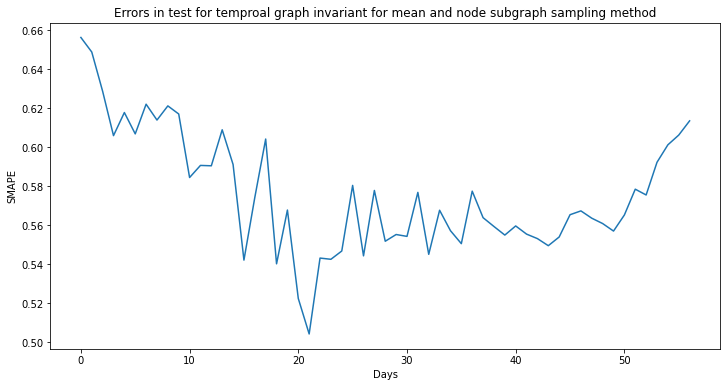

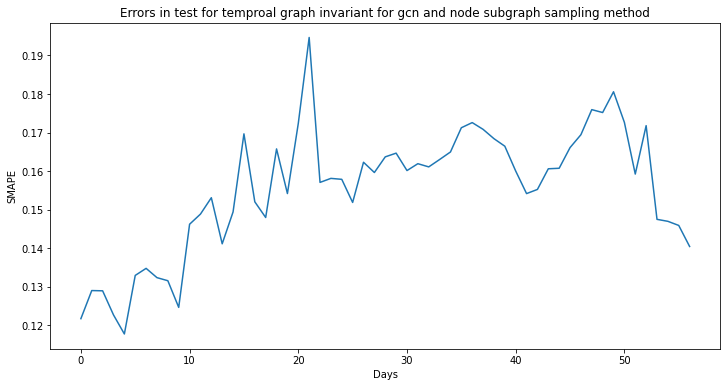

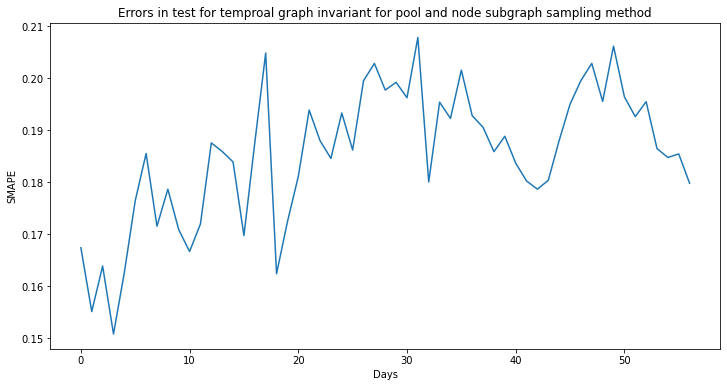

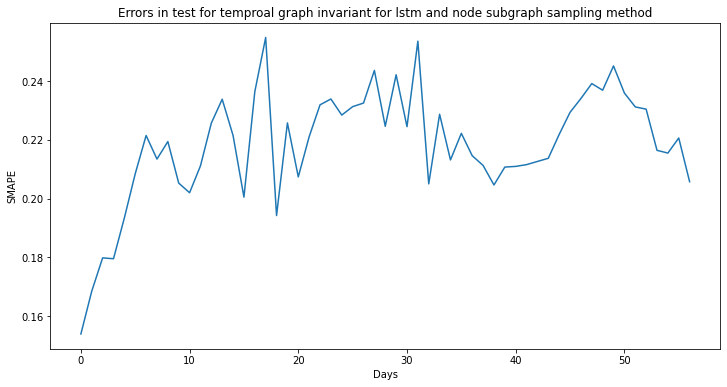

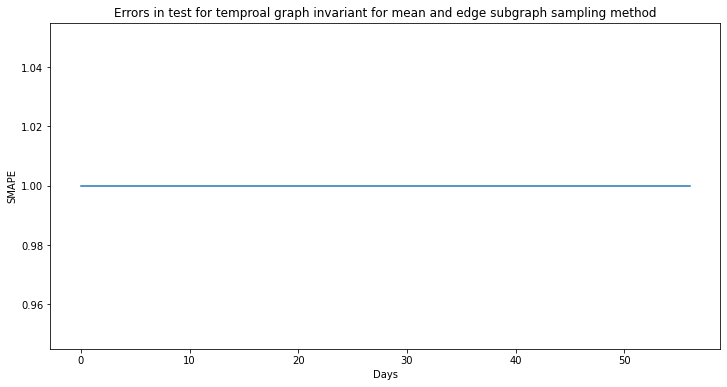

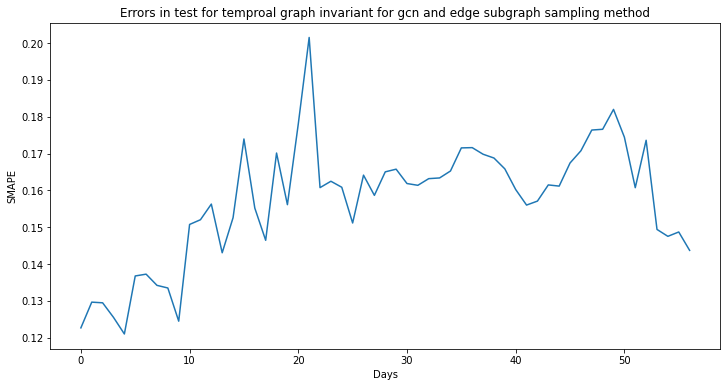

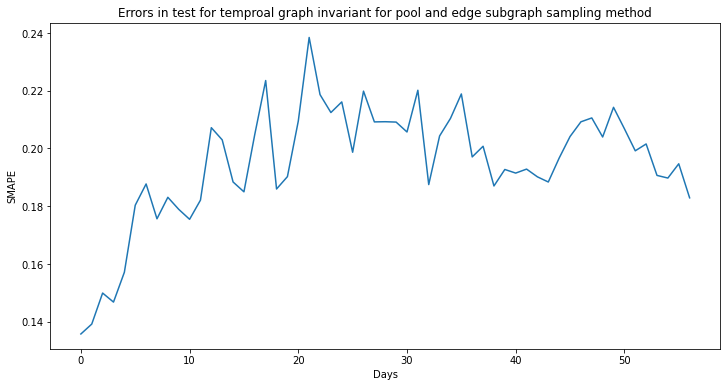

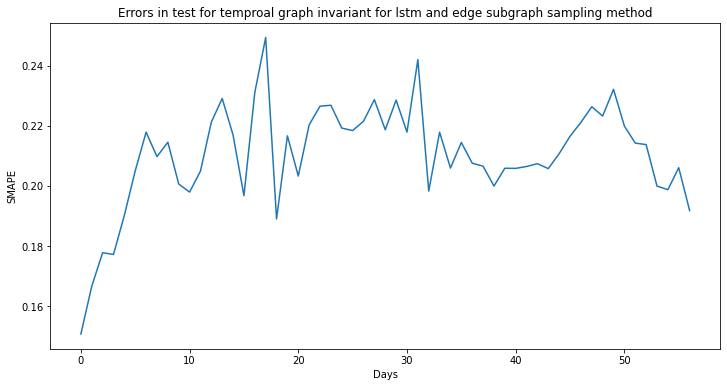

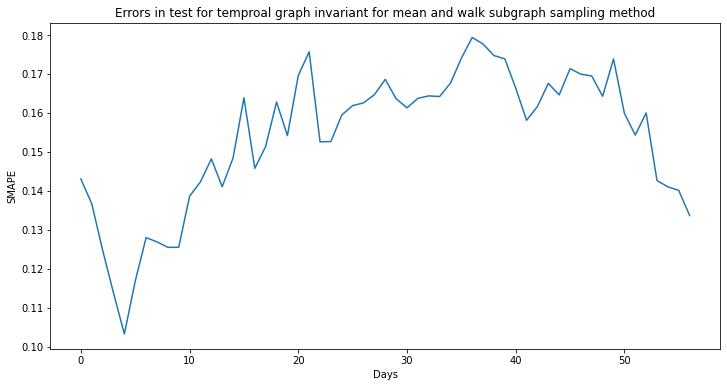

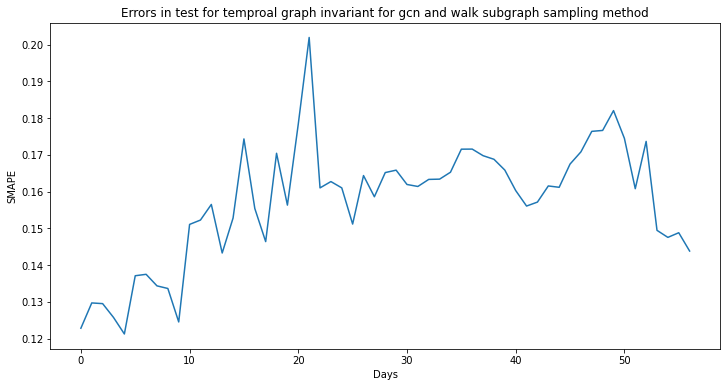

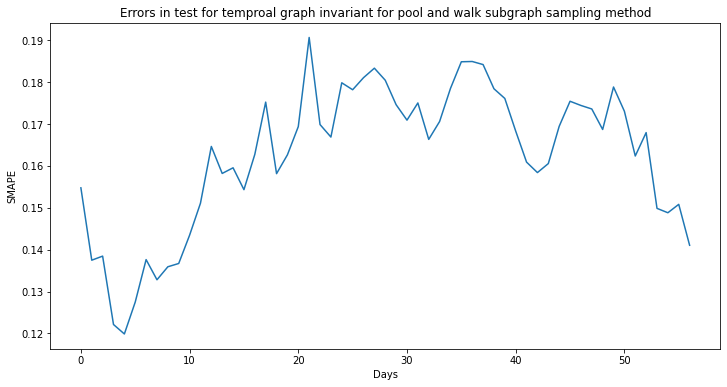

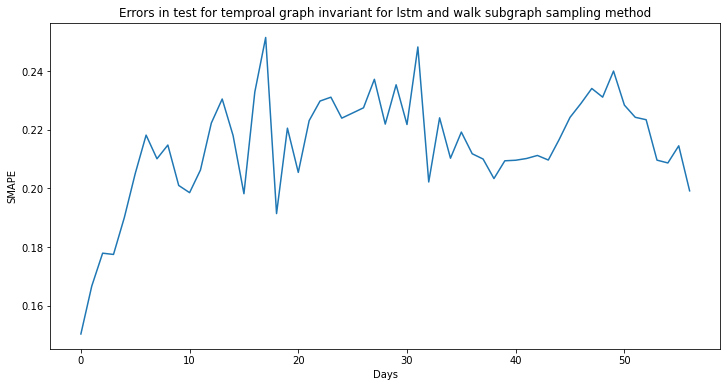

In [ ]:
# RESULT PLOTTING AND COMPARISONS
for subgraph_type in subgraph_types:
  temporal_result = temporal_tight_all_result[subgraph_type]
  for agg_type, results in temporal_result.items():
      plt.figure(figsize=(12,6))
      plt.title("Errors in test for temproal graph invariant" + f" for {agg_type} and " + f"{subgraph_type} subgraph sampling method")
      plt.xlabel("Days")
      plt.ylabel("SMAPE")
      plt.plot(results)
      print("Errors in test for temporal time invariant" + f" for {agg_type} and " + f"{subgraph_type} subgraph sampling method")
      print("mean:",sum(results)/len(results))
      results = np.array(results)
      print("std:", np.std(results))
      print()

In [ ]:
overall_agg_results =[]
overall_agg_forecasts = []
for model_type in ["dynamic_node"]:
  for model in temporal_dyn_model_node_models:
    results =[]
    forecasts = []
    for i in range(test_modified_input.shape[0]):
      result, forecast = Test(model,graph=temporal_covid_graph,features=torch.tensor(test_temporal_input[i], dtype=float),labels=torch.tensor(test_temporal_val[i], dtype=float), isTemporal=True)
      results.append(result)
      forecasts.append(forecast)
    forecasts = np.array(forecasts)
    overall_agg_results.append(results)
    overall_agg_forecasts.append(forecasts)
    plt.plot(results)

In [ ]:
overall_agg_results = {x: [] for x in model_types }
overall_agg_forecasts = {x: [] for x in model_types }
for model_type in model_types:
  for model in covid_graph_models[model_type]:
    results =[]
    forecasts = []
    for i in range(test_modified_input.shape[0]):
      result, forecast = Test(model,graph=covid_graph,features=torch.tensor(test_modified_input[i], dtype=float),labels=torch.tensor(test_modified_val[i], dtype=float))
      results.append(result)
      forecasts.append(forecast)
    forecasts = np.array(forecasts)
    overall_agg_results[model_type].append(results)
    overall_agg_forecasts[model_type].append(forecasts)

In [ ]:
# agg_results = []
# agg_forecast = []
# for model in dyn_model_edge_models: 
#   results = []
#   forecasts = []
#   for i in range(test_modified_input.shape[0]):
#       result, forecast = Test(model,graph=covid_graph,features=torch.tensor(test_modified_input[i], dtype=float),labels=torch.tensor(test_modified_val[i], dtype=float))
#       results.append(result)
#       forecasts.append(forecast)
#   forecasts = np.array(forecasts)
#   agg_results.append(results)
#   agg_forecast.append(forecasts)
# # overall_agg_results.append()

Errors in test dynamic_edge for mean
mean: 0.03973204757038796
std: 0.01648087820245083

Errors in test dynamic_edge for gcn
mean: 0.14632222667399242
std: 0.01951275194810864

Errors in test dynamic_edge for pool
mean: 0.05551900851085156
std: 0.022362360137379578

Errors in test dynamic_edge for lstm
mean: 0.04311438316599101
std: 0.02930553810013053

Errors in test dynamic_node for mean
mean: 0.03145166373478447
std: 0.018466427048704354

Errors in test dynamic_node for gcn
mean: 0.14322574678242211
std: 0.01794204238375674

Errors in test dynamic_node for pool
mean: 0.060074775585847805
std: 0.027870400076819297

Errors in test dynamic_node for lstm
mean: 0.035161965137913816
std: 0.019183243296548122

Errors in test dynamic_walk for mean
mean: 0.03726968421627548
std: 0.021675028738535957

Errors in test dynamic_walk for gcn
mean: 0.15367272119071596
std: 0.02106638448494695

Errors in test dynamic_walk for pool
mean: 0.09473709948980884
std: 0.024910791885821838

Errors in test d

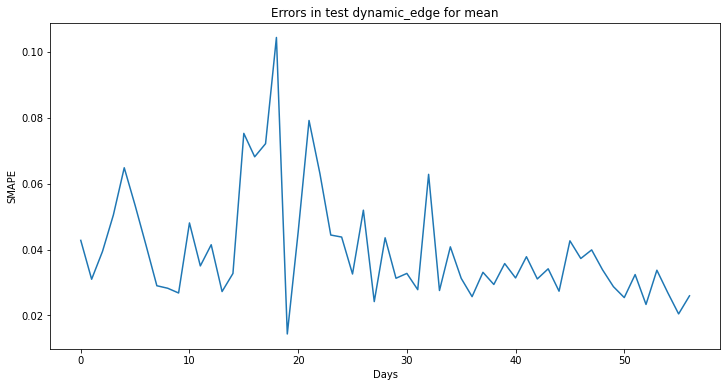

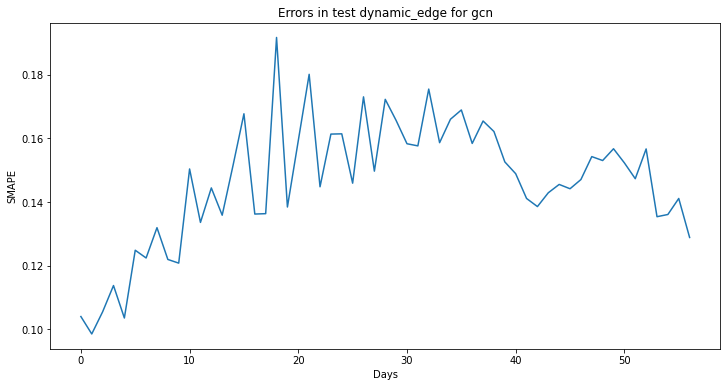

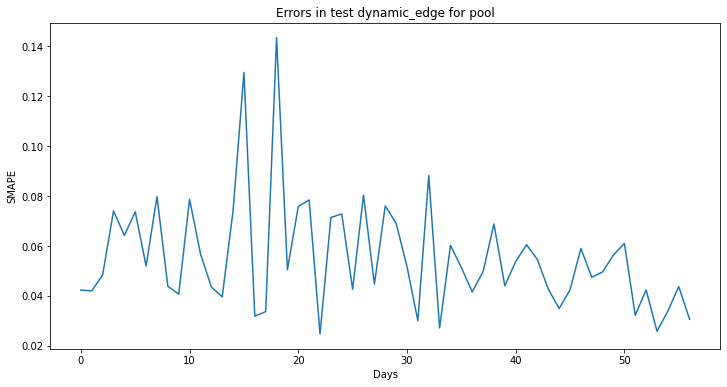

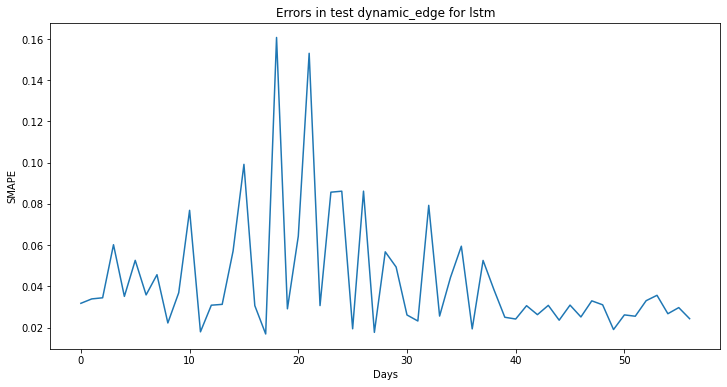

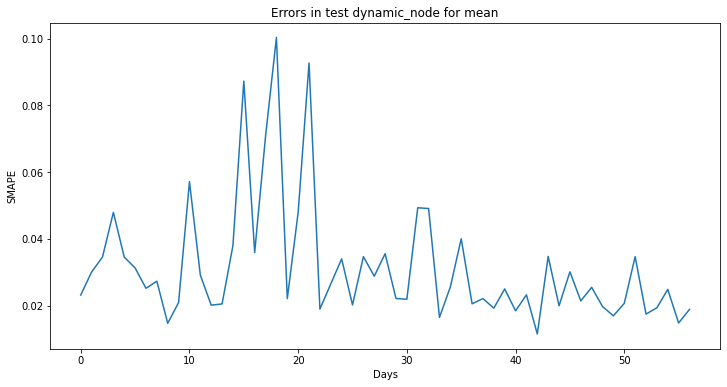

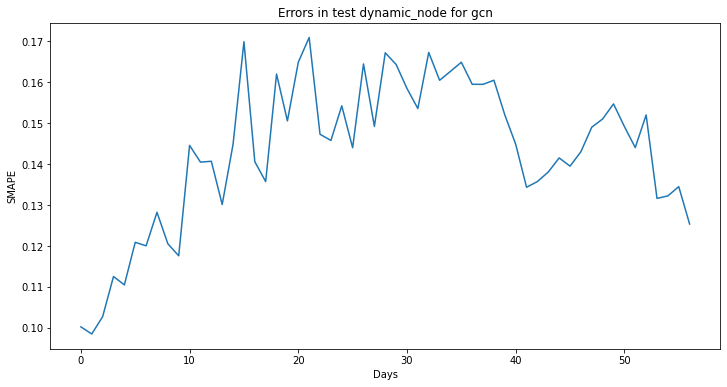

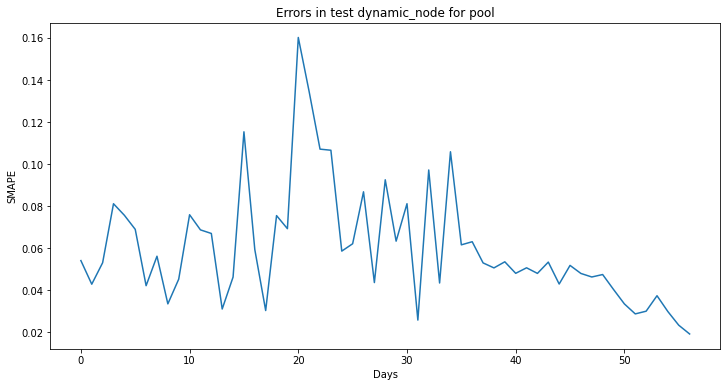

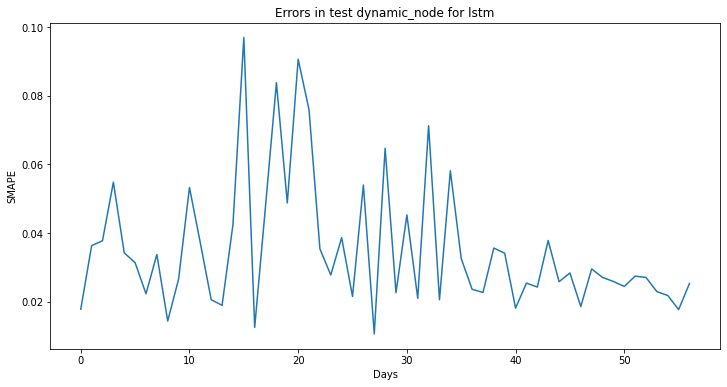

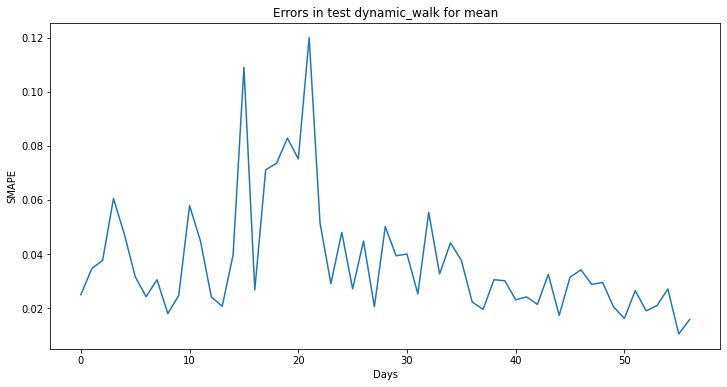

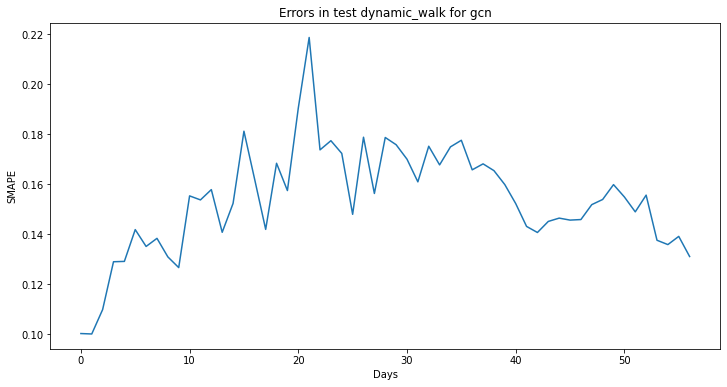

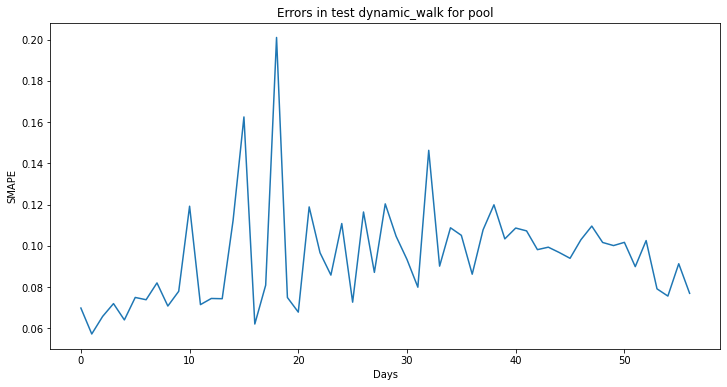

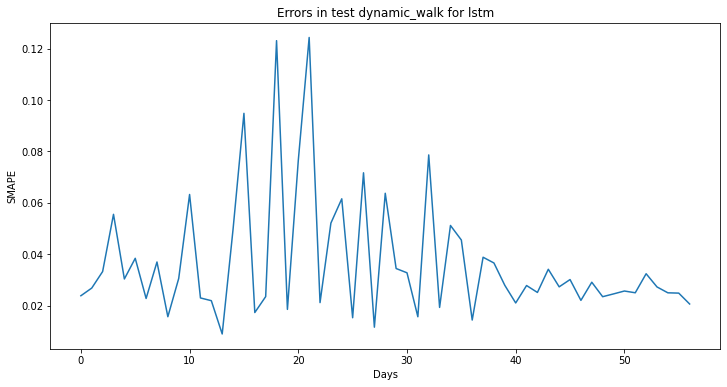

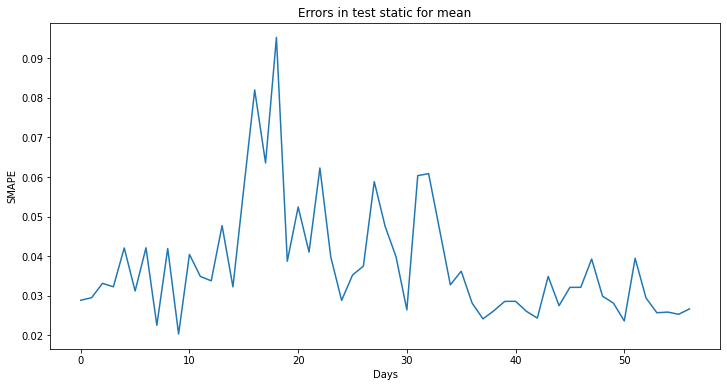

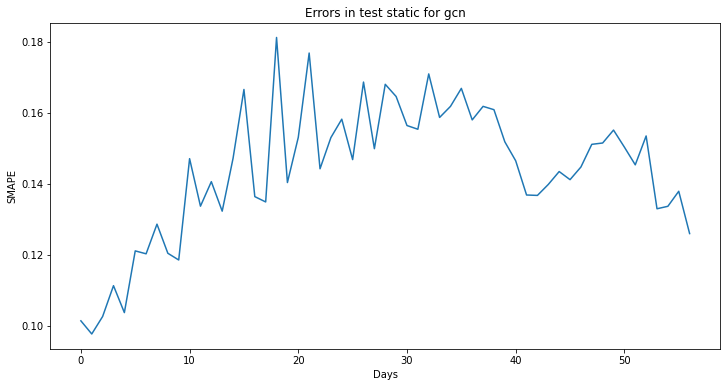

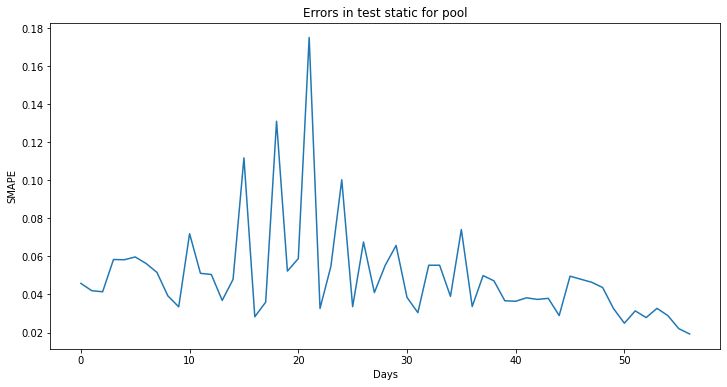

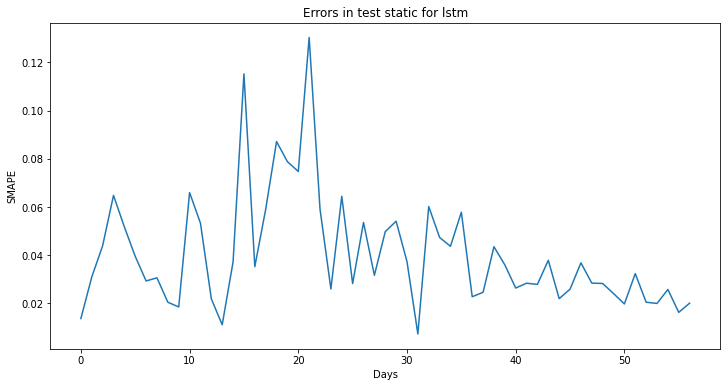

In [ ]:
for model_type in model_types:
  for i in range(len(agg_types)):
    results = overall_agg_results[model_type][i]
    plt.figure(figsize=(12,6))
    plt.title("Errors in test "+str(model_type)+f" for {agg_types[i]}")
    plt.xlabel("Days")
    plt.ylabel("SMAPE")
    plt.plot(results)
    print("Errors in test "+str(model_type)+f" for {agg_types[i]}")
    print("mean:",sum(results)/len(results))
    results = np.array(results)
    print("std:", np.std(results))
    print()

In [ ]:
# for i in range(len(agg_types)):
#   results = agg_results[i]
#   plt.figure(figsize=(12,6))
#   plt.title(f"Errors in test for {agg_types[i]}")
#   plt.xlabel("Days")
#   plt.ylabel("SMAPE")
#   plt.plot(results)
#   print("mean:",sum(results)/len(results))
#   results = np.array(results)
#   print("std:", np.std(results))
#   print()

In [ ]:
print(test_modified_input.shape)

(57, 18, 4)


In [ ]:
results = []
forecasts = []
for i in range(test_modified_input.shape[0]):
  result, forecast = Test(model,graph=covid_graph,features=torch.tensor(test_modified_input[i], dtype=float),labels=torch.tensor(test_modified_val[i], dtype=float))
  results.append(result)
  forecasts.append(forecast)
forecasts = np.array(forecasts)

Testing SMAPE: 0.017974594896768534
Testing SMAPE: 0.0964304815622013
Testing SMAPE: 0.09238106074765905
Testing SMAPE: 0.12799679392483282
Testing SMAPE: 0.11374422835773486
Testing SMAPE: 0.07111014496696898
Testing SMAPE: 0.06247440307977576
Testing SMAPE: 0.06926304222631646
Testing SMAPE: 0.05767883437491392
Testing SMAPE: 0.03674231408302271
Testing SMAPE: 0.10834123015946949
Testing SMAPE: 0.1175174733933064
Testing SMAPE: 0.05464901452851242
Testing SMAPE: 0.08590304829022899
Testing SMAPE: 0.0636534449335852
Testing SMAPE: 0.20188275375063083
Testing SMAPE: 0.09029717874719528
Testing SMAPE: 0.1511624246998925
Testing SMAPE: 0.07111054959899582
Testing SMAPE: 0.1630689013037164
Testing SMAPE: 0.2392690006378306
Testing SMAPE: 0.13340432550525555
Testing SMAPE: 0.17554862644788066
Testing SMAPE: 0.08409245780690731
Testing SMAPE: 0.07631285982146364
Testing SMAPE: 0.10484283262244481
Testing SMAPE: 0.06490058410725065
Testing SMAPE: 0.05837595229883333
Testing SMAPE: 0.12238060

[0.05890086195110437, 0.07505838861057025, 0.09092381280794298, 0.13447495995859593, 0.11042896768798406, 0.0898076721254268, 0.06778823991106361, 0.07594374077162548, 0.04942069363509815, 0.0425378184439587, 0.11211993193044795, 0.09476090266077117, 0.06699340775242377, 0.07923909107896424, 0.05552645098151014, 0.21087990604449344, 0.04199629158972753, 0.26564269184285716, 0.1279021257968307, 0.17347756647702717, 0.08279808049464893, 0.1287664359334196, 0.062081555713199066, 0.19157549433026896, 0.08501834173352556, 0.04136554512880344, 0.07187384151106245, 0.04805229814584172, 0.06595251875258945, 0.07399690651978912, 0.059991188012424285, 0.11332871073825708, 0.0786342703602088, 0.055448450910828395, 0.054888312606270716, 0.09563713123049439, 0.04951863508850898, 0.08333689108761867, 0.06373330413372685, 0.061056532745595145, 0.07412732412064388, 0.06500184141085717, 0.04514562732854463, 0.06251947978361595, 0.031126977751697666, 0.06977920257258807, 0.07344310826584238, 0.064315533

0.07986266278691756

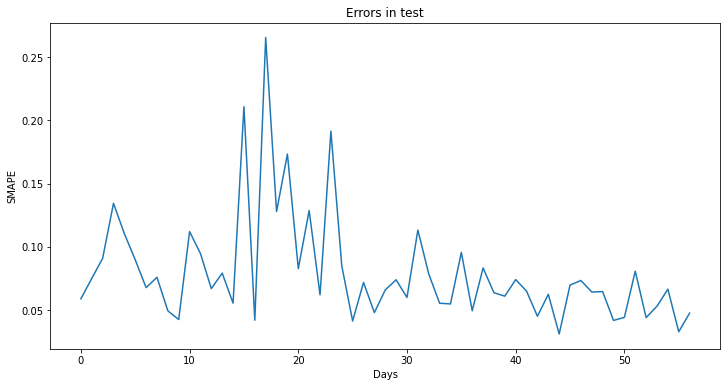

In [ ]:
# Plotting days against the testing's forecast SMAPE
plt.figure(figsize=(12,6))
plt.title("Errors in test")
plt.xlabel("Days")
plt.ylabel("SMAPE")
plt.plot(results)
print(results)
sum(results)/len(results)

In [ ]:
dyn_results = []
dyn_forecasts = []
for i in range(test_modified_input.shape[0]):
  result, forecast = Test(dyn_model,graph=covid_graph,features=torch.tensor(test_modified_input[i], dtype=float),labels=torch.tensor(test_modified_val[i], dtype=float))
  dyn_results.append(result)
  dyn_forecasts.append(forecast)
dyn_forecasts = np.array(dyn_forecasts)

Testing SMAPE: 0.06680979001499197
Testing SMAPE: 0.09143788181478392
Testing SMAPE: 0.09084308923732312
Testing SMAPE: 0.12085101567945077
Testing SMAPE: 0.07406121800627288
Testing SMAPE: 0.07230962352101601
Testing SMAPE: 0.0716441160300985
Testing SMAPE: 0.08276763839569284
Testing SMAPE: 0.047089020317919
Testing SMAPE: 0.06073264990054531
Testing SMAPE: 0.12295688257748123
Testing SMAPE: 0.08039928962054034
Testing SMAPE: 0.0507506309420582
Testing SMAPE: 0.04838189988136093
Testing SMAPE: 0.08731340780306861
Testing SMAPE: 0.20740078766007958
Testing SMAPE: 0.04199960751793209
Testing SMAPE: 0.11999424650386592
Testing SMAPE: 0.20270687830505796
Testing SMAPE: 0.11999261653903526
Testing SMAPE: 0.1309798630606504
Testing SMAPE: 0.21439323389384277
Testing SMAPE: 0.06619840379852764
Testing SMAPE: 0.07867058092987182
Testing SMAPE: 0.11119917117944746
Testing SMAPE: 0.05398643961344932
Testing SMAPE: 0.1022620666470037
Testing SMAPE: 0.041184110951662994
Testing SMAPE: 0.10606043

[0.06680979001499197, 0.09143788181478392, 0.09084308923732312, 0.12085101567945077, 0.07406121800627288, 0.07230962352101601, 0.0716441160300985, 0.08276763839569284, 0.047089020317919, 0.06073264990054531, 0.12295688257748123, 0.08039928962054034, 0.0507506309420582, 0.04838189988136093, 0.08731340780306861, 0.20740078766007958, 0.04199960751793209, 0.11999424650386592, 0.20270687830505796, 0.11999261653903526, 0.1309798630606504, 0.21439323389384277, 0.06619840379852764, 0.07867058092987182, 0.11119917117944746, 0.05398643961344932, 0.1022620666470037, 0.041184110951662994, 0.10606043556301158, 0.07500593113011728, 0.07525098933772166, 0.04919718399925557, 0.13933884107021577, 0.0611414389427376, 0.08714156740339354, 0.09396870386353301, 0.04343372808441713, 0.05325192545754198, 0.07131160204602315, 0.06614358911094295, 0.05760770771030202, 0.06303375513120767, 0.04971901958993168, 0.07596166822480445, 0.04298141812069424, 0.07195284513634977, 0.05405635331939191, 0.0495556542177035

0.0800279861618362

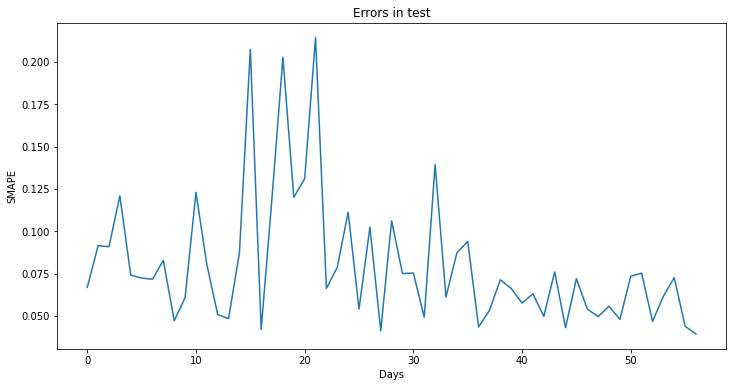

In [ ]:
# Plotting days against the testing's forecast SMAPE
plt.figure(figsize=(12,6))
plt.title("Errors in test")
plt.xlabel("Days")
plt.ylabel("SMAPE")
plt.plot(dyn_results)
print(dyn_results)
sum(dyn_results)/len(dyn_results)

In [ ]:
# Plotting the model's forecast result against the actual result

forecast_districts = []
real_forecasts = []
def draw(i):
  plt.figure(figsize=(12,6))
  plt.title("Forecasts "+str(districts[i]))
  plt.xlabel("Days")
  plt.ylabel("Cases")
  forecast_district = forecasts[:,i]
  real_forecast = test_modified_val[:,i]
  plt.plot(forecast_district, label="forecast")
  plt.plot(real_forecast, label="actual")
  plt.legend(loc="upper right")
  forecast_districts.append(forecast_district)
  real_forecasts.append(real_forecast)
  plt.savefig("/content/drive/MyDrive/COMP 4222/Forecasts_"+str(districts[i])+".png")
# [draw(i) for i in range(18)]
# for i in range(1):
#   forecast_district = (forecasts[:,i]).reshape(57,1)
#   real_forecast = (test_modified_val[:,i]).reshape(57,1)
#   result = sum(abs(forecast_district - real_forecast))
print(forecasts.shape)
print(test_modified_val.shape)
forecast_test= forecasts.reshape(57,18,1)
test_modified_val_test=  test_modified_val.reshape(57,18,1)
result = forecast_test - test_modified_val_test
print(result.shape)
results = [float(sum(abs(result[:,i]))) for i in range(18)]
results


(57, 18)
(57, 18, 1)
(57, 18, 1)


[1037.807921109652,
 1068.8770595156425,
 717.6871779099159,
 1198.9335834204871,
 813.266593573898,
 843.2884253135878,
 925.1961064526175,
 767.2373007302592,
 1117.440152232305,
 1059.5688513436908,
 589.028269095218,
 931.22015926271,
 975.0882903698275,
 832.9467167223631,
 867.2521389948846,
 851.9783495386007,
 1012.2024215225008,
 941.1705183969151]

In [ ]:
print(np.array(forecast_districts[0]), np.array(real_forecasts[1: ]))

IndexError: ignored

## Testing our model with data from Sep 1st - Oct 31st
Regarded as special forecast since the date is disconnected form the training model dates

In [10]:
#This is using Sep and Oct 2022 data
import pandas as pd
sp_test_csv_pds = []
sp_test_dates = []
for file in os.listdir("/content/drive/MyDrive/COMP 4222/data_Sep1_Oct31"):
    if file.endswith(".csv"):
        sp_test_csv_pds.append(pd.read_csv("/content/drive/MyDrive/COMP 4222/data_Sep1_Oct31/"+file,on_bad_lines="skip"))
        sp_test_dates.append(file[0:8])

In [11]:
from difflib import SequenceMatcher
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

districts = ['Central & Western', 'Eastern', 'Islands', 'Kowloon City', 'Kwai Tsing',
 'Kwun Tong', 'North', 'Sai Kung', 'Sham Shui Po', 'Sha Tin', 'Southern',
 'Tai Po', 'Tsuen Wan', 'Tuen Mun', 'Wan Chai', 'Wong Tai Sin', 'Yau Tsim Mong',
 'Yuen Long']

iter =0
for csv in sp_test_csv_pds:
  csv["District"] = csv.apply(lambda row: districts[np.argmax(np.array([similar(row["District"],key) for key in districts]))], axis=1)
  count = csv['District'].unique()
  if len(count) != 18:
    print("failed entry recorded") 
  print(iter, end=" ")
  iter +=1

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 

In [12]:
sp_test_series_count_district ={}
for district in districts:
    sp_test_series_count_district[district] = []

In [13]:
for pd in sp_test_csv_pds:
    for district in districts:
          sp_test_series_count_district[district].append((pd['District'] == district).sum())

In [14]:
sp_test_district_series = []
for district in districts:
  sp_test_district_series.append(sp_test_series_count_district[district])

In [15]:
sp_test_modified_input = []
sp_test_modified_val = []
for sequence in sp_test_district_series:
    input_sequence = [sequence[i:i+window_size] for i in range(0,len(sequence)-4)]
    val_sequence = [[sequence[i+window_size] for i in range(0,len(sequence)-4)]]
    sp_test_modified_input.append(input_sequence)
    sp_test_modified_val.append(np.array(val_sequence))

sp_test_modified_input = np.array(sp_test_modified_input)
sp_test_modified_val=  np.array(sp_test_modified_val)
sp_test_modified_val = sp_test_modified_val.reshape(18,-1,1)
sp_test_modified_input = np.array([sp_test_modified_input[:,x,:] for x in range(len(sequence)-4)])
sp_test_modified_val = np.array([sp_test_modified_val[:,x,:] for x in range(len(sequence)-4)])
sp_test_temporal_input = sp_test_modified_input.reshape(sp_test_modified_input.shape[0],-1)
sp_test_temporal_val = np.squeeze(np.concatenate((np.expand_dims(sp_test_modified_input[:,:,-3], axis=2),np.expand_dims(sp_test_modified_input[:,:,-2], axis=2),np.expand_dims(sp_test_modified_input[:,:,-1], axis=2), sp_test_modified_val),axis=1))

## **Discontinuous Testing STATIC TIMEINVARIANT**

In [46]:
agg_types = ["mean","gcn","pool","lstm"]
subgraph_types = ["node","edge","walk"]
sp_static_result = {x: [] for x in agg_types}
sp_static_forecast = {x: [] for x in agg_types} 
for i in range(4):
  model = stats_model[i]
  agg = agg_types[i]
  results = []
  forecasts = []
  for i in range(sp_test_modified_input.shape[0]):
    result, forecast = Test(model,graph=covid_graph,features=torch.tensor(sp_test_modified_input[i], dtype=float),labels=torch.tensor(sp_test_modified_val[i], dtype=float))
    results.append(result)
    forecasts.append(forecast)
  forecasts = np.array(forecasts)
  sp_static_result[agg] = results
  sp_static_forecast[agg] = forecasts

Testing SMAPE: 0.06799479791274944
Testing SMAPE: 0.1209528183694184
Testing SMAPE: 0.07056243461868685
Testing SMAPE: 0.06319894244786804
Testing SMAPE: 0.05734645385862507
Testing SMAPE: 0.06723189043641759
Testing SMAPE: 0.2661479593933433
Testing SMAPE: 0.09939425211460941
Testing SMAPE: 0.06934077820708645
Testing SMAPE: 0.0986984905070255
Testing SMAPE: 0.06101458999814989
Testing SMAPE: 0.05739803620079106
Testing SMAPE: 0.053757805328204095
Testing SMAPE: 0.0785198341350636
Testing SMAPE: 0.07844829973182829
Testing SMAPE: 0.06463388925726005
Testing SMAPE: 0.07790104063140237
Testing SMAPE: 0.05803379408496233
Testing SMAPE: 0.10747415782786525
Testing SMAPE: 0.061535860899635524
Testing SMAPE: 0.14476104396124026
Testing SMAPE: 0.060777281163528984
Testing SMAPE: 0.08114877696250915
Testing SMAPE: 0.10334477998182953
Testing SMAPE: 0.06273627595090768
Testing SMAPE: 0.12789833691913446
Testing SMAPE: 0.07866607917797508
Testing SMAPE: 0.09704171275833864
Testing SMAPE: 0.0633

Errors in test for static time invariant for mean
mean: 0.08695946596996097
std: 0.040595666250698985

Errors in test for static time invariant for gcn
mean: 0.1286182998382914
std: 0.029606031163194334

Errors in test for static time invariant for pool
mean: 0.06928640254759019
std: 0.05834549759029109

Errors in test for static time invariant for lstm
mean: 0.0555511702855912
std: 0.051511228572623996



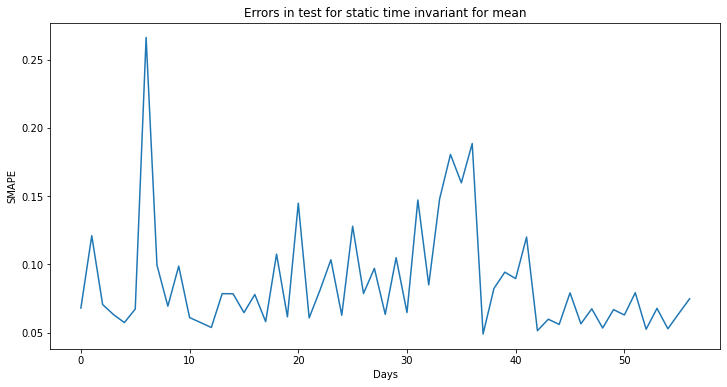

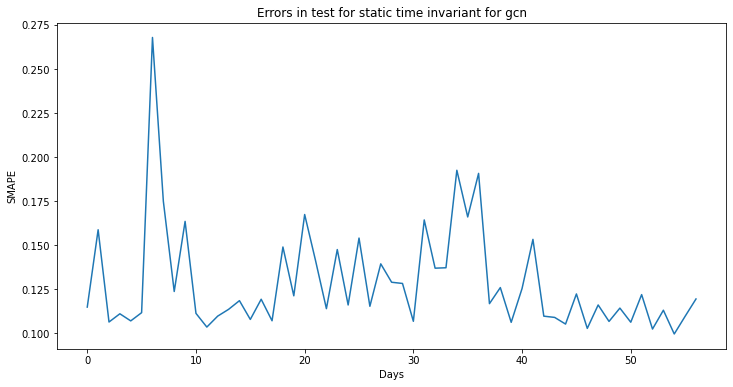

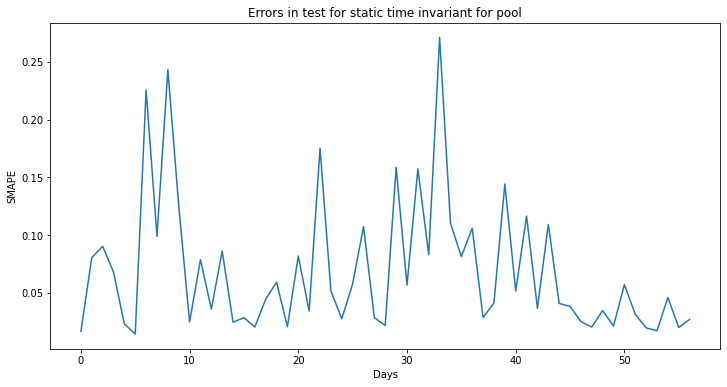

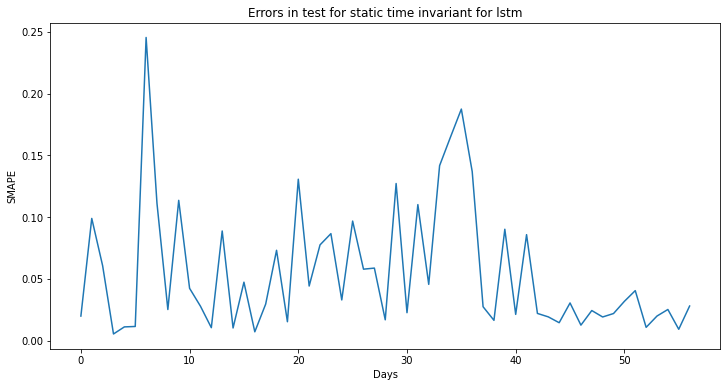

In [47]:
# RESULT PLOTTING AND COMPARISONS
for agg_type, results in sp_static_result.items():
    plt.figure(figsize=(12,6))
    plt.title("Errors in test for static time invariant" + f" for {agg_type}")
    plt.xlabel("Days")
    plt.ylabel("SMAPE")
    plt.plot(results)
    print("Errors in test for static time invariant" + f" for {agg_type}")
    print("mean:",sum(results)/len(results))
    results = np.array(results)
    print("std:", np.std(results))
    print()

# **Discontinuous Testing Dynamic TIME INVARIANT**

In [50]:
sp_dynamic_all_result = {x: [] for x in subgraph_types}
sp_dynamic_all_forecast = {x: [] for x in subgraph_types}

for subgraph_type in subgraph_types:
  sp_dynamic_result = {x: [] for x in agg_types}
  sp_dynamic_forecast = {x: [] for x in agg_types}
  sp_dynamic_model = dynamic_models[subgraph_type]
  for i in range(4):
    model = sp_dynamic_model[i]
    agg = agg_types[i]
    results = []
    forecasts = []
    for i in range(sp_test_modified_input.shape[0]):
      result, forecast = Test(model,graph=covid_graph,features=torch.tensor(sp_test_modified_input[i], dtype=float),labels=torch.tensor(sp_test_modified_val[i], dtype=float))
      results.append(result)
      forecasts.append(forecast)
    forecasts = np.array(forecasts)
    sp_dynamic_result[agg] = results
    sp_dynamic_forecast[agg] = forecasts
  sp_dynamic_all_result[subgraph_type] = (sp_dynamic_result)
  sp_dynamic_all_forecast[subgraph_type] = (sp_dynamic_forecast)

Testing SMAPE: 0.04003617977455925
Testing SMAPE: 0.1181866267495016
Testing SMAPE: 0.04789471439594808
Testing SMAPE: 0.05654444171722915
Testing SMAPE: 0.045177425812430706
Testing SMAPE: 0.04582310568054481
Testing SMAPE: 0.25267054279516304
Testing SMAPE: 0.16549665769424932
Testing SMAPE: 0.15719821833066483
Testing SMAPE: 0.07725622570175646
Testing SMAPE: 0.03692480590273875
Testing SMAPE: 0.047480377629935636
Testing SMAPE: 0.027894472842645703
Testing SMAPE: 0.045431369726538884
Testing SMAPE: 0.04503350000858711
Testing SMAPE: 0.042436162563308094
Testing SMAPE: 0.04568436970572346
Testing SMAPE: 0.026106684896495827
Testing SMAPE: 0.0953597780301896
Testing SMAPE: 0.05511848252830156
Testing SMAPE: 0.11275703494145471
Testing SMAPE: 0.06609705921111145
Testing SMAPE: 0.12826244105943982
Testing SMAPE: 0.04484573597910985
Testing SMAPE: 0.05933720920498167
Testing SMAPE: 0.08628941783418988
Testing SMAPE: 0.0573643812051209
Testing SMAPE: 0.04341614999087731
Testing SMAPE: 0.

Errors in test for dynamic time invariant for mean and node subgraph sampling method
mean: 0.07329273741987044
std: 0.05047198320714613

Errors in test for dynamic time invariant for gcn and node subgraph sampling method
mean: 0.1307865410776423
std: 0.03104812972566618

Errors in test for dynamic time invariant for pool and node subgraph sampling method
mean: 0.07657367728231713
std: 0.06263631335287517

Errors in test for dynamic time invariant for lstm and node subgraph sampling method
mean: 0.054667567743212506
std: 0.04890233560869131

Errors in test for dynamic time invariant for mean and edge subgraph sampling method
mean: 0.06636911858993814
std: 0.04727817456019638

Errors in test for dynamic time invariant for gcn and edge subgraph sampling method
mean: 0.1324863675132819
std: 0.03437199037016495

Errors in test for dynamic time invariant for pool and edge subgraph sampling method
mean: 0.08358245528615547
std: 0.045808757141625536

Errors in test for dynamic time invariant f

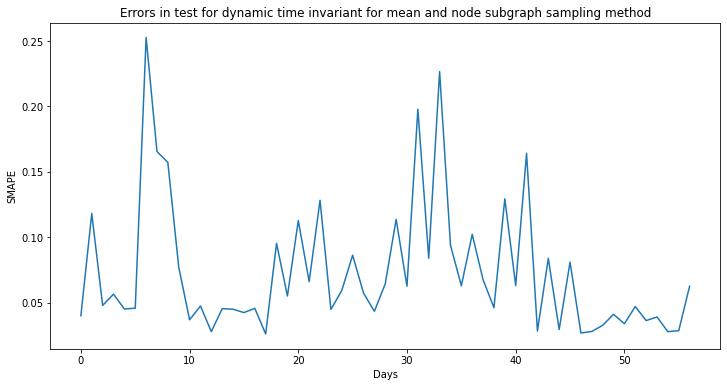

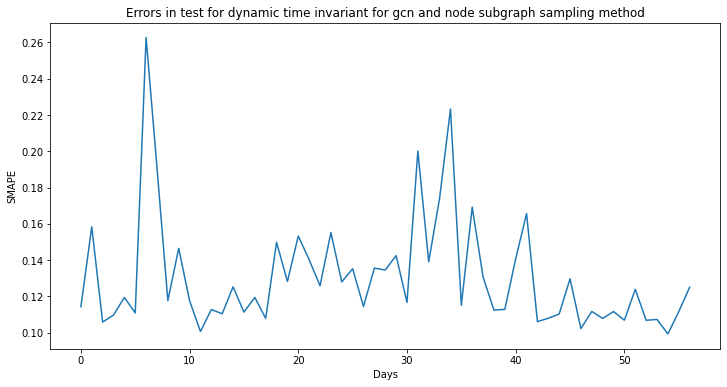

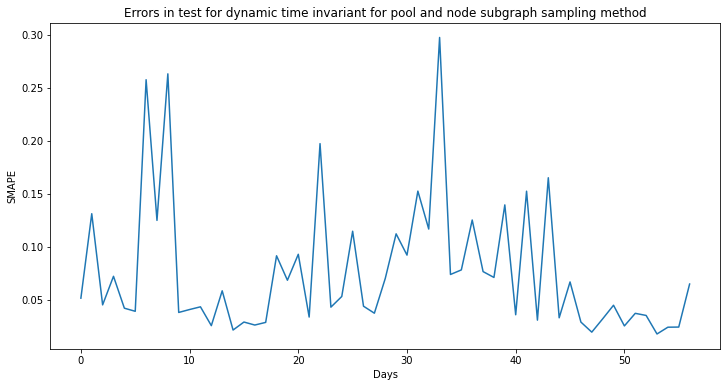

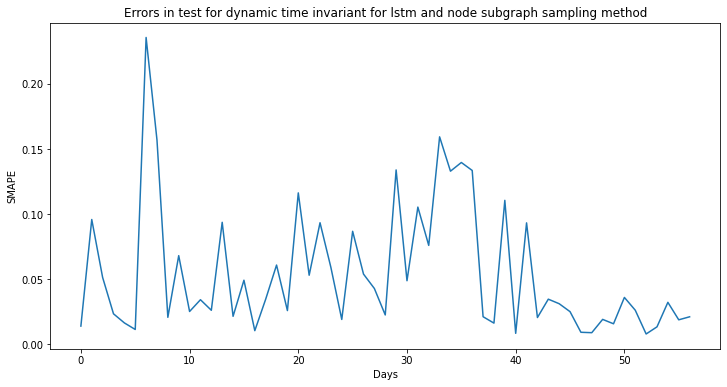

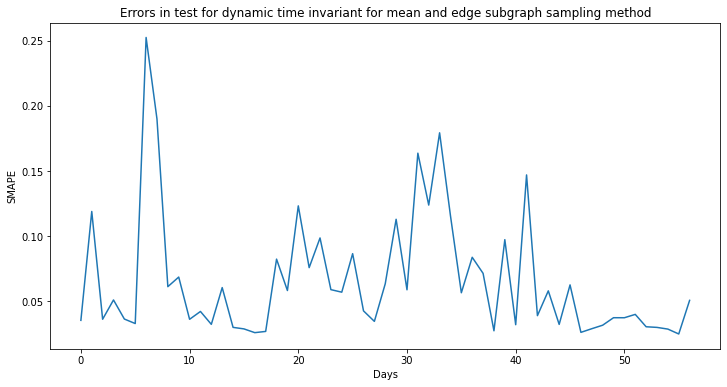

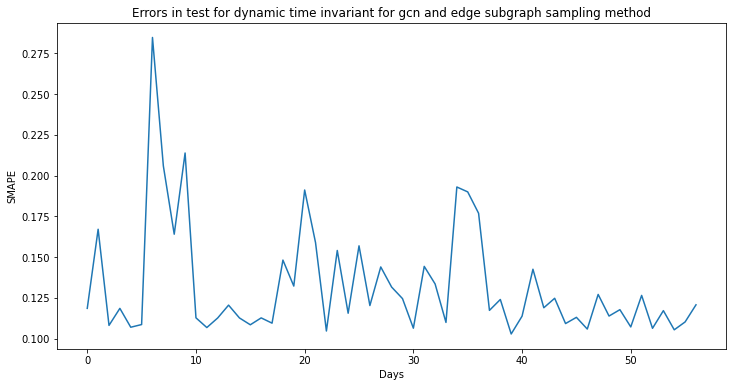

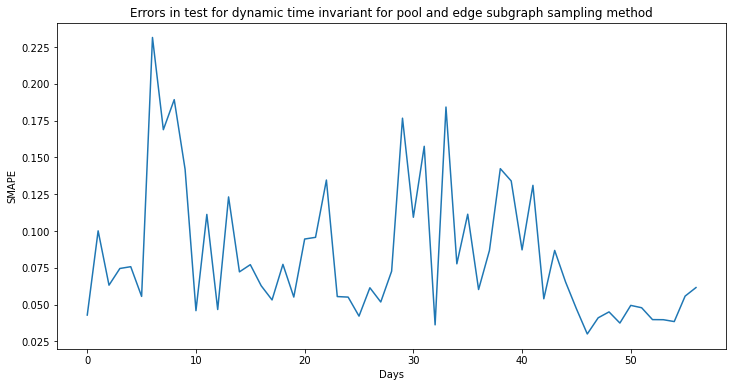

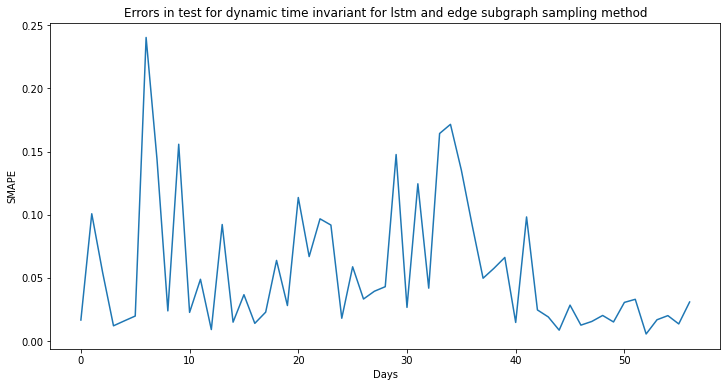

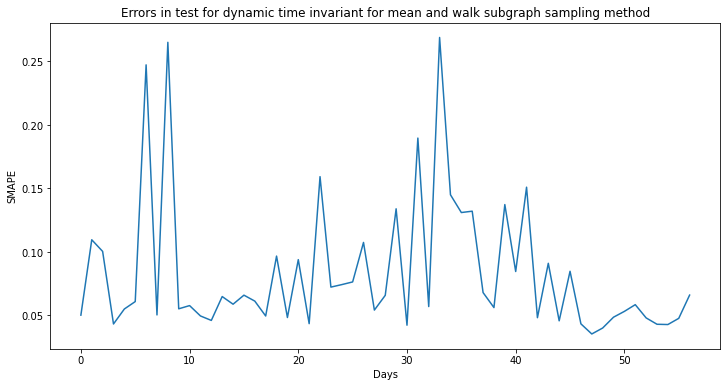

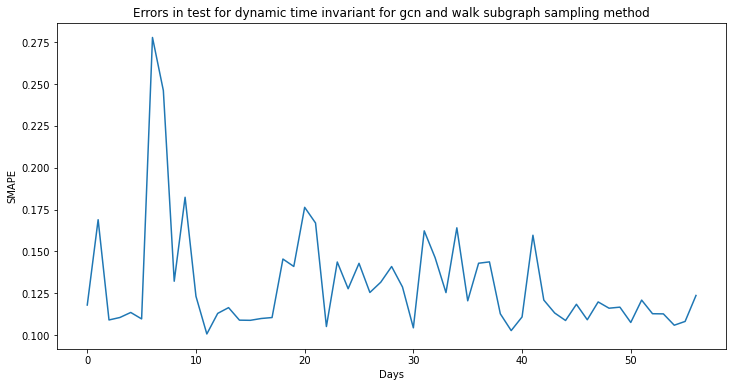

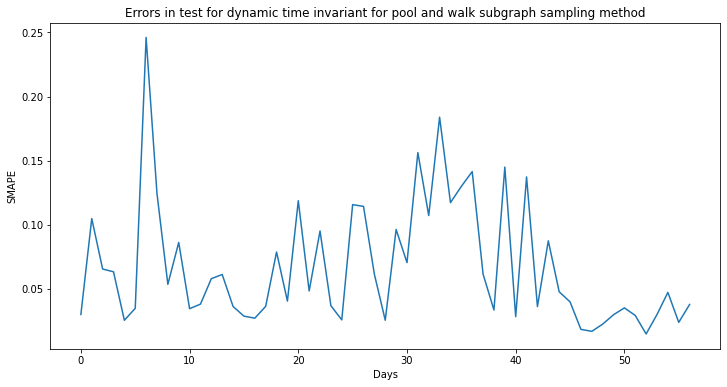

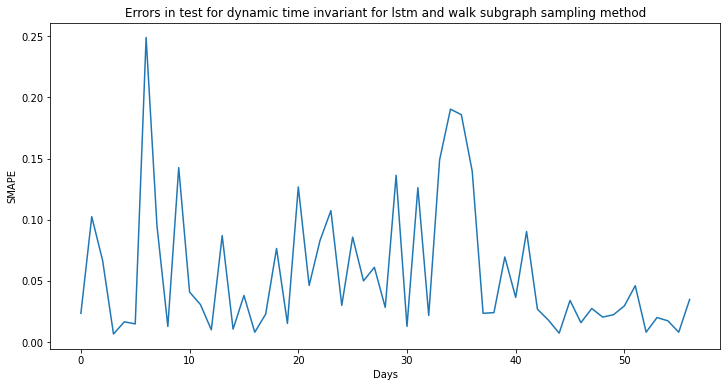

In [51]:
# RESULT PLOTTING AND COMPARISONS
for subgraph_type in subgraph_types:
  dynamic_result = sp_dynamic_all_result[subgraph_type]
  for agg_type, results in dynamic_result.items():
      plt.figure(figsize=(12,6))
      plt.title("Errors in test for dynamic time invariant" + f" for {agg_type} and " + f"{subgraph_type} subgraph sampling method")
      plt.xlabel("Days")
      plt.ylabel("SMAPE")
      plt.plot(results)
      print("Errors in test for dynamic time invariant" + f" for {agg_type} and " + f"{subgraph_type} subgraph sampling method")
      print("mean:",sum(results)/len(results))
      results = np.array(results)
      print("std:", np.std(results))
      print()

# **Discontinuous Testing Temporal Graph**

In [62]:
sp_temporal_all_result = {x: [] for x in subgraph_types}
sp_temporal_all_forecast = {x: [] for x in subgraph_types}

for subgraph_type in subgraph_types:
  sp_temporal_result = {x: [] for x in agg_types}
  sp_temporal_forecast = {x: [] for x in agg_types}
  sp_temporal_model = temporal_dyn_model_node_models[subgraph_type]
  for i in range(4):
    model = sp_temporal_model[i]
    agg = agg_types[i]
    results = []
    forecasts = []
    for i in range(sp_test_modified_input.shape[0]):
      result, forecast = Test(model,graph=temporal_covid_graph,features=torch.tensor(sp_test_temporal_input[i], dtype=float),labels=torch.tensor(sp_test_temporal_val[i], dtype=float), isTemporal=True)
      results.append(result)
      forecasts.append(forecast)
    forecasts = np.array(forecasts)
    sp_temporal_result[agg] = results
    sp_temporal_forecast[agg] = forecasts
  sp_temporal_all_result[subgraph_type] = sp_temporal_result
  sp_temporal_all_forecast[subgraph_type] = sp_temporal_forecast

Testing SMAPE: 0.1483727173246366
Testing SMAPE: 0.1749644874497239
Testing SMAPE: 0.15824355038540294
Testing SMAPE: 0.142716430703571
Testing SMAPE: 0.143807559200967
Testing SMAPE: 0.14049254654061838
Testing SMAPE: 0.24986042096140965
Testing SMAPE: 0.23007507831822707
Testing SMAPE: 0.16401030898516283
Testing SMAPE: 0.17736451118887672
Testing SMAPE: 0.14946439390980076
Testing SMAPE: 0.1319972346694146
Testing SMAPE: 0.1442723802646086
Testing SMAPE: 0.1563578077222276
Testing SMAPE: 0.13847549156702607
Testing SMAPE: 0.1506851808896275
Testing SMAPE: 0.131725198780851
Testing SMAPE: 0.1462770394095599
Testing SMAPE: 0.1470410027111942
Testing SMAPE: 0.15532998544745563
Testing SMAPE: 0.1724091596610007
Testing SMAPE: 0.1719726916632271
Testing SMAPE: 0.1520295883529265
Testing SMAPE: 0.14027610263088494
Testing SMAPE: 0.15193340165821487
Testing SMAPE: 0.14304696930122202
Testing SMAPE: 0.1614210597219072
Testing SMAPE: 0.13711578647635098
Testing SMAPE: 0.15425423395996157
Tes

Errors in test for temporal time invariant for mean and node subgraph sampling method
mean: 0.15214276395728052
std: 0.02095405609336633

Errors in test for temporal time invariant for gcn and node subgraph sampling method
mean: 0.15099951254858732
std: 0.01966463726490885

Errors in test for temporal time invariant for pool and node subgraph sampling method
mean: 0.15709496530941602
std: 0.018779585420137582

Errors in test for temporal time invariant for lstm and node subgraph sampling method
mean: 0.214119521563813
std: 0.027318755158968203

Errors in test for temporal time invariant for mean and edge subgraph sampling method
mean: 0.1544248713918184
std: 0.023986502536772227

Errors in test for temporal time invariant for gcn and edge subgraph sampling method
mean: 0.1537863136316241
std: 0.02325862769411314

Errors in test for temporal time invariant for pool and edge subgraph sampling method
mean: 0.21372382329846018
std: 0.024895594765748905

Errors in test for temporal time inv

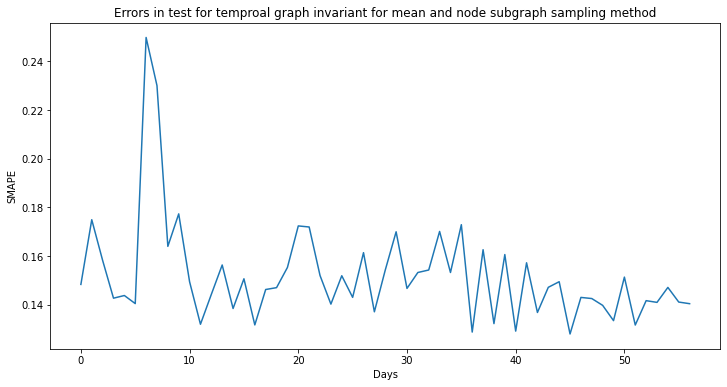

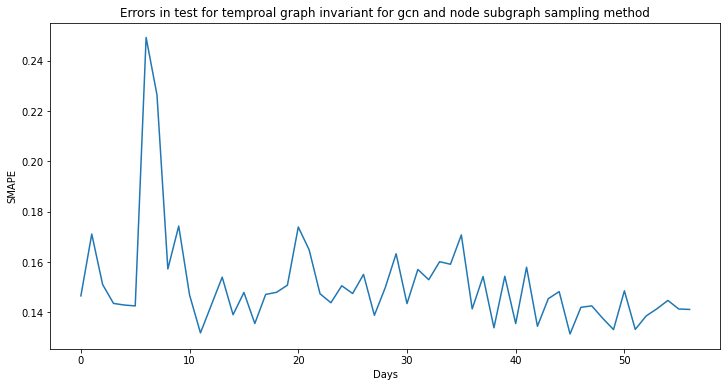

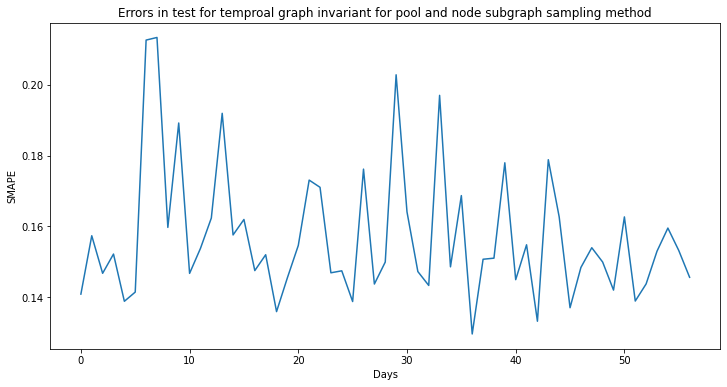

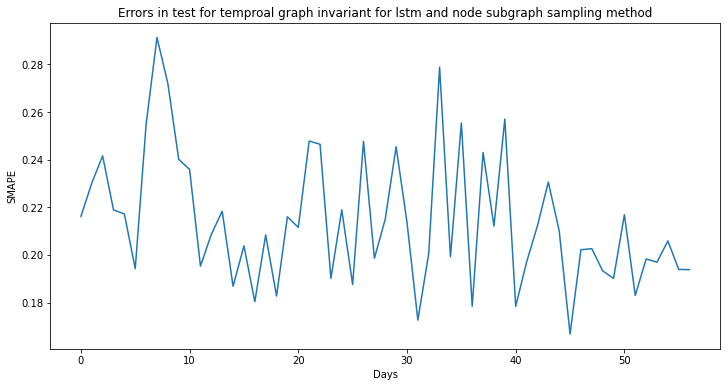

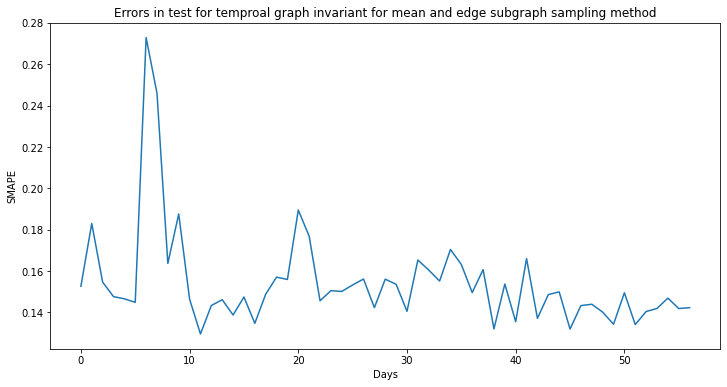

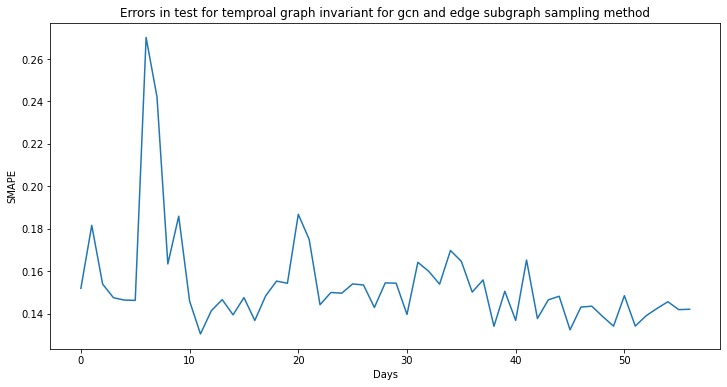

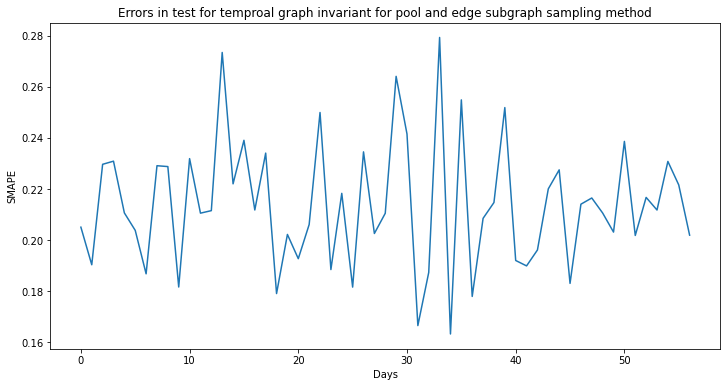

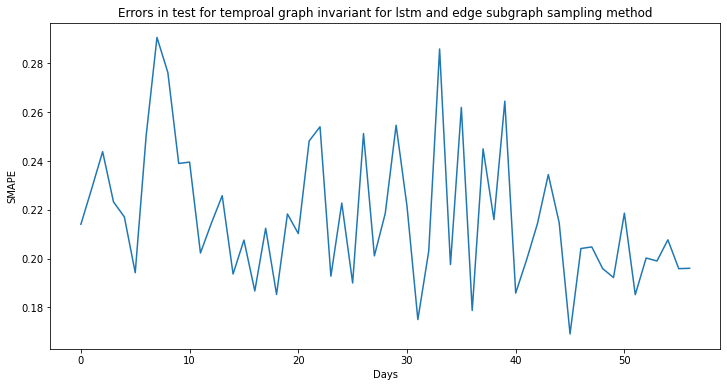

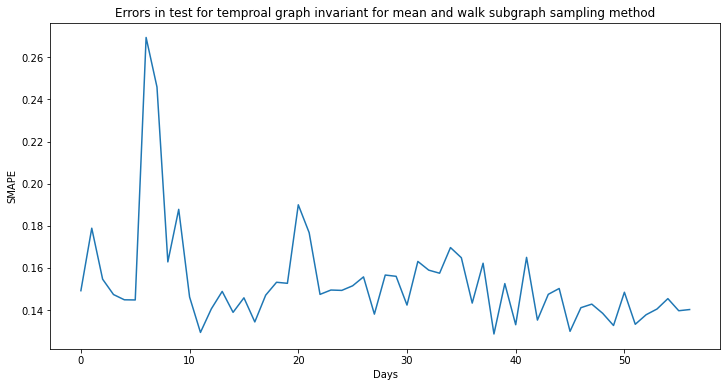

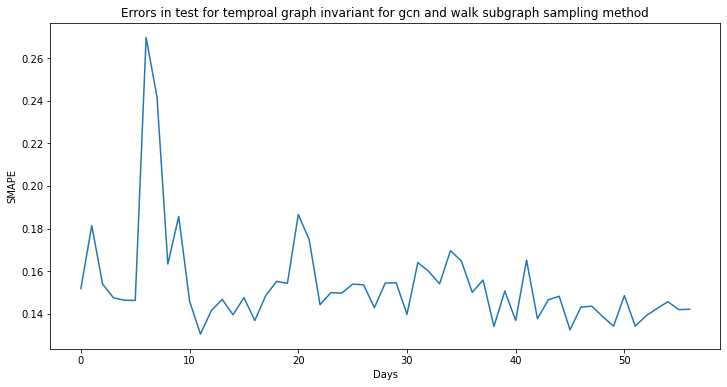

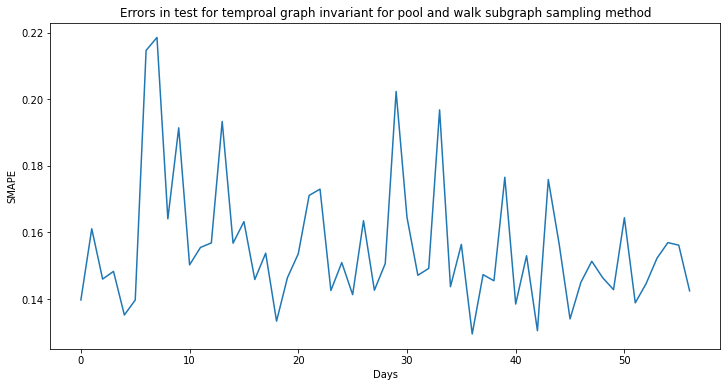

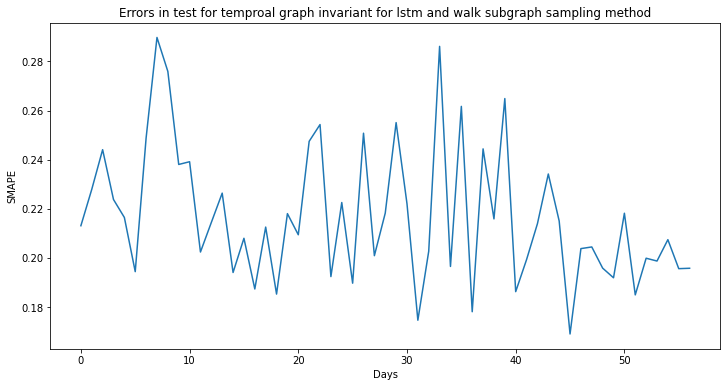

In [63]:
# RESULT PLOTTING AND COMPARISONS
for subgraph_type in subgraph_types:
  temporal_result = sp_temporal_all_result[subgraph_type]
  for agg_type, results in temporal_result.items():
      plt.figure(figsize=(12,6))
      plt.title("Errors in test for temproal graph invariant" + f" for {agg_type} and " + f"{subgraph_type} subgraph sampling method")
      plt.xlabel("Days")
      plt.ylabel("SMAPE")
      plt.plot(results)
      print("Errors in test for temporal time invariant" + f" for {agg_type} and " + f"{subgraph_type} subgraph sampling method")
      print("mean:",sum(results)/len(results))
      results = np.array(results)
      print("std:", np.std(results))
      print()

# **Discontinuous Testing Tight Temporal Graph**

In [ ]:
sp_temporal_tight_all_result = {x: [] for x in subgraph_types}
sp_temporal_tight_all_forecast = {x: [] for x in subgraph_types}

for subgraph_type in subgraph_types:
  temporal_tight_result = {x: [] for x in agg_types}
  temporal_tight_forecast = {x: [] for x in agg_types}
  temporal_tight_model = temporal_tight_dyn_model_node_models[subgraph_type]
  for i in range(4):
    model = temporal_tight_model[i]
    agg = agg_types[i]
    results = []
    forecasts = []
    for i in range(test_modified_input.shape[0]):
      result, forecast = Test(model,graph=temporal_covid_graph,features=torch.tensor(test_temporal_input[i], dtype=float),labels=torch.tensor(test_temporal_val[i], dtype=float), isTemporal=True)
      results.append(result)
      forecasts.append(forecast)
    forecasts = np.array(forecasts)
    temporal_tight_result[agg] = results
    temporal_tight_forecast[agg] = forecasts
  sp_temporal_tight_all_result[subgraph_type] = (temporal_tight_result)
  sp_temporal_tight_all_forecast[subgraph_type] = (temporal_tight_forecast)

Testing SMAPE: 0.604606751007406
Testing SMAPE: 0.5435055712611119
Testing SMAPE: 0.6158244171227335
Testing SMAPE: 0.6221694758877042
Testing SMAPE: 0.615100336909227
Testing SMAPE: 0.6198850669782112
Testing SMAPE: 0.44041198574908
Testing SMAPE: 0.430178056788688
Testing SMAPE: 0.5214895814905002
Testing SMAPE: 0.48432126091134586
Testing SMAPE: 0.6163325608182513
Testing SMAPE: 0.631947488514255
Testing SMAPE: 0.6255861282803427
Testing SMAPE: 0.683001359859384
Testing SMAPE: 0.6497074956652329
Testing SMAPE: 0.6583192220541816
Testing SMAPE: 0.6390729662741846
Testing SMAPE: 0.6415316237775363
Testing SMAPE: 0.5857390620998035
Testing SMAPE: 0.5852280657269718
Testing SMAPE: 0.5232340279483225
Testing SMAPE: 0.5307753528103061
Testing SMAPE: 0.6400520790475291
Testing SMAPE: 0.5752232041349091
Testing SMAPE: 0.6154092504473433
Testing SMAPE: 0.5637278153366108
Testing SMAPE: 0.6142411693832963
Testing SMAPE: 0.6005792983787264
Testing SMAPE: 0.5857025889631854
Testing SMAPE: 0.686

Errors in test for temporal time invariant for mean and node subgraph sampling method
mean: 0.6024028401667992
std: 0.05391456840403176

Errors in test for temporal time invariant for gcn and node subgraph sampling method
mean: 0.15186966697926263
std: 0.02096608134742251

Errors in test for temporal time invariant for pool and node subgraph sampling method
mean: 0.1718547344410062
std: 0.02079371384592696

Errors in test for temporal time invariant for lstm and node subgraph sampling method
mean: 0.22117170519966523
std: 0.028230897970703814

Errors in test for temporal time invariant for mean and edge subgraph sampling method
mean: 1.0
std: 0.0

Errors in test for temporal time invariant for gcn and edge subgraph sampling method
mean: 0.15345819164448296
std: 0.02288355134258535

Errors in test for temporal time invariant for pool and edge subgraph sampling method
mean: 0.17590552600072917
std: 0.024566044316343433

Errors in test for temporal time invariant for lstm and edge subgrap

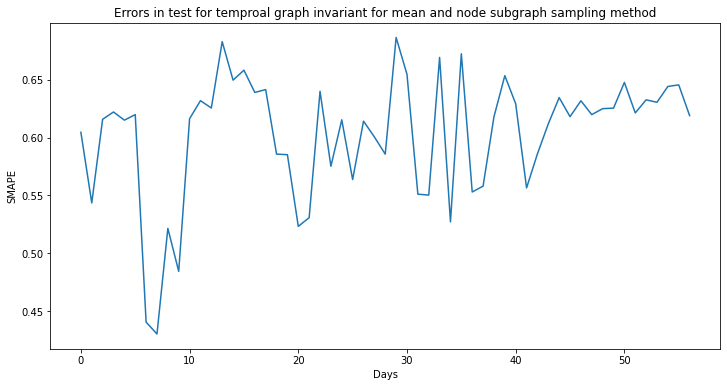

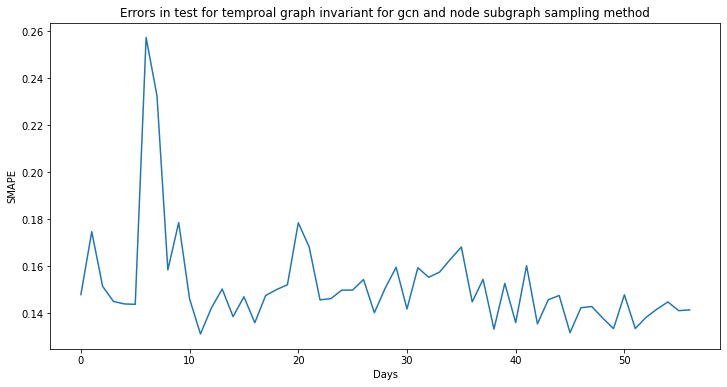

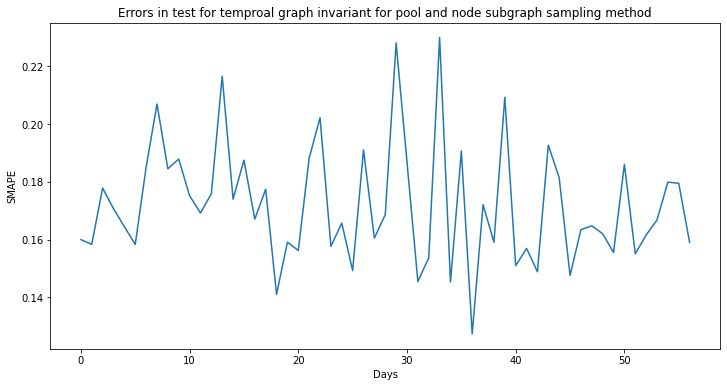

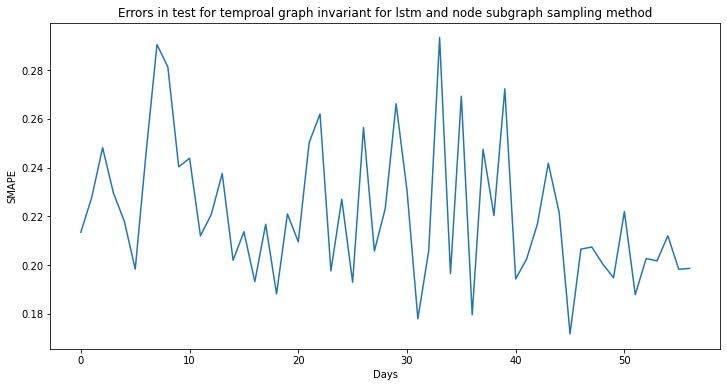

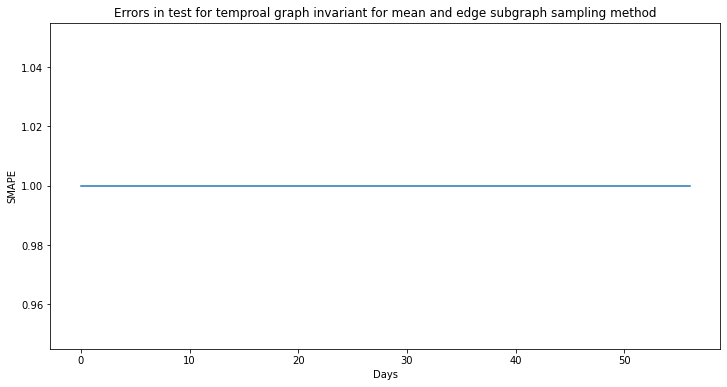

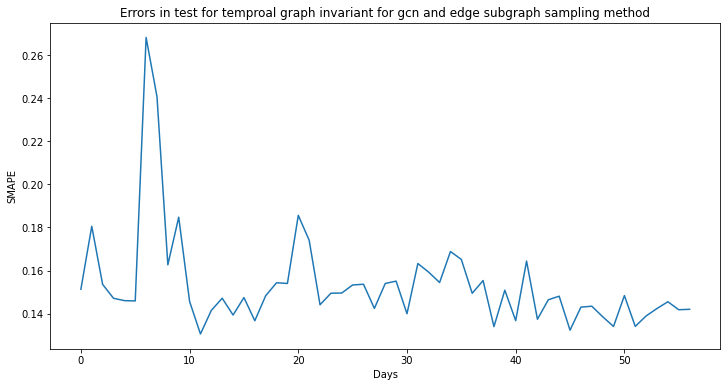

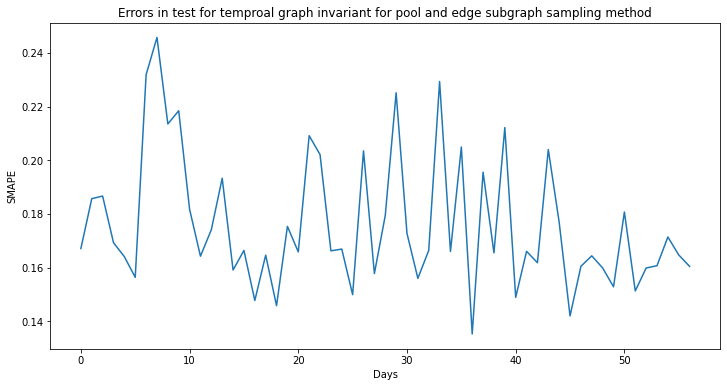

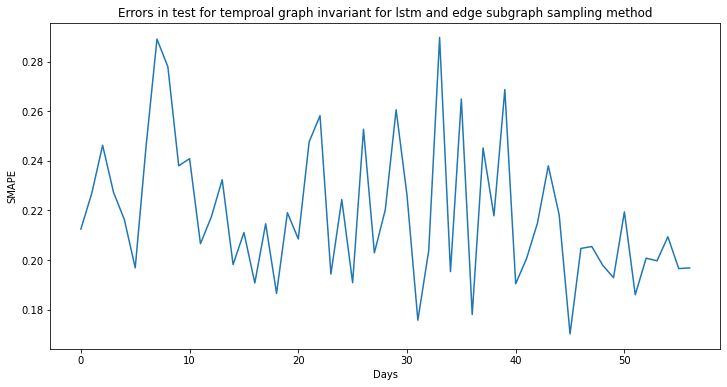

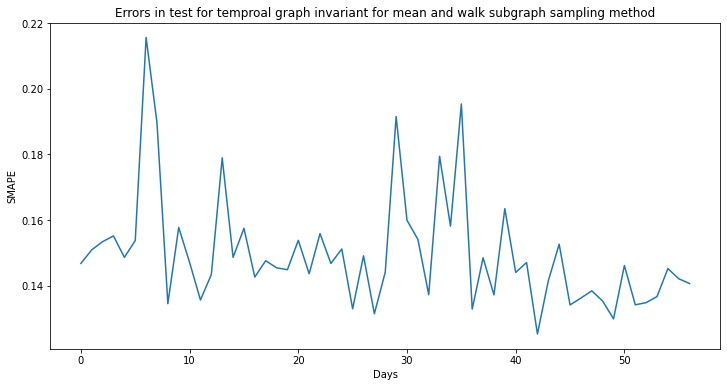

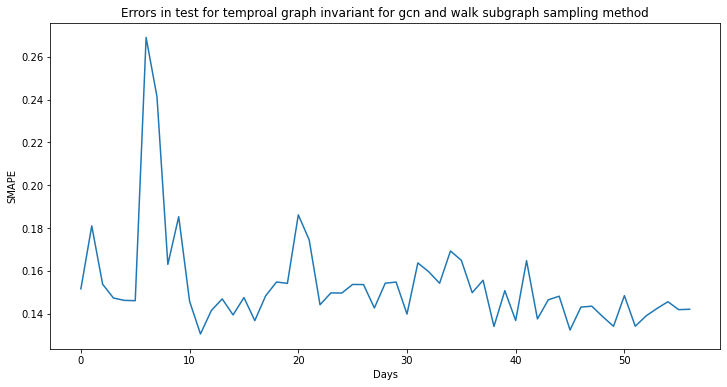

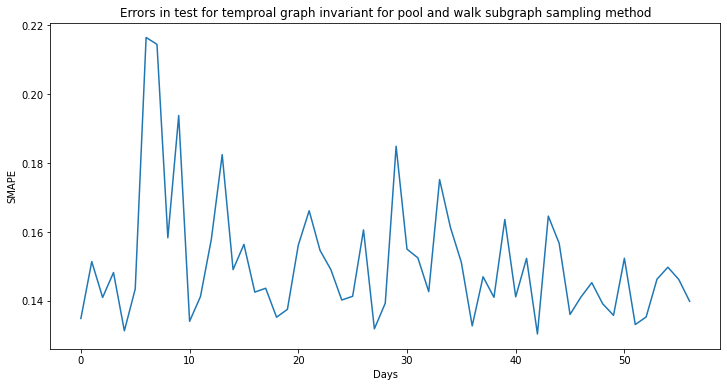

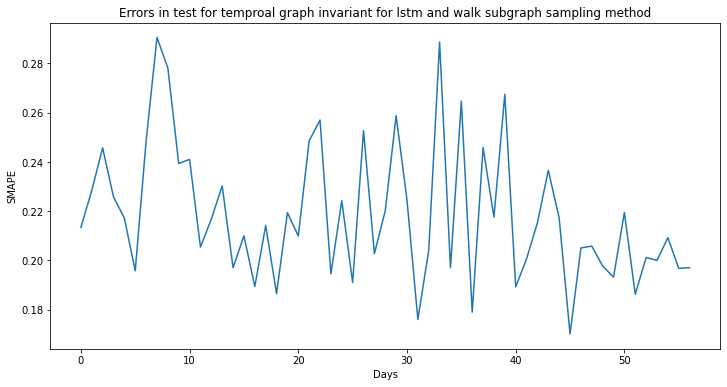

In [ ]:
# RESULT PLOTTING AND COMPARISONS
for subgraph_type in subgraph_types:
  temporal_result = sp_temporal_tight_all_result[subgraph_type]
  for agg_type, results in temporal_result.items():
      plt.figure(figsize=(12,6))
      plt.title("Errors in test for temproal graph invariant" + f" for {agg_type} and " + f"{subgraph_type} subgraph sampling method")
      plt.xlabel("Days")
      plt.ylabel("SMAPE")
      plt.plot(results)
      print("Errors in test for temporal time invariant" + f" for {agg_type} and " + f"{subgraph_type} subgraph sampling method")
      print("mean:",sum(results)/len(results))
      results = np.array(results)
      print("std:", np.std(results))
      print()

In [ ]:
asdf  = np.array([0.77847142 ,0.71789106 ,1.4729841  ,0.55027135 ,0.4079975  ,0.51269839
, 0.46149646 ,0.38077966 ,0.43828766 ,0.62145498 ,1.29356967 ,0.62880601
 ,0.49520789 ,0.5814485  ,1.38456217 ,0.51501099 ,0.53993516 ,0.6393137 ])
asdf = asdf/2
print(asdf.mean())
print(asdf.std())


0.3450051852777778
0.16346669475763598


In [ ]:
sp_results = []
sp_forecasts = []
for i in range(test_modified_input.shape[0]):
  sp_result, sp_forecast = Test(model,graph=covid_graph,features=torch.tensor(sp_test_modified_input[i], dtype=float),labels=torch.tensor(sp_test_modified_val[i], dtype=float))
  sp_results.append(sp_result)
  sp_forecasts.append(sp_forecast)
sp_forecasts = np.array(sp_forecasts)

In [ ]:
# Plotting days against the testing's forecast SMAPE
plt.figure(figsize=(12,6))
plt.title("Errors in test")
plt.xlabel("Days")
plt.ylabel("SMAPE")
plt.plot(sp_results)
# print(sp_results)

In [ ]:
# Plotting the model's special forecast result against the actual result
def draw(i):
  plt.figure(figsize=(12,6))
  plt.title("Specical Forecasts "+str(districts[i]))
  plt.xlabel("Days")
  plt.ylabel("Cases")
  sp_forecast_district = sp_forecasts[:,i]
  sp_real_forecast = sp_test_modified_val[:,i]
  plt.plot(sp_forecast_district, label="forecast")
  plt.plot(sp_real_forecast, label="actual")
  plt.legend(loc="upper right")
  # plt.savefig("/content/drive/MyDrive/COMP 4222/Future_Forecasts_"+str(districts[i])+".svg")
# [draw(i) for i in range(18)]
forecast_test= sp_forecasts.reshape(57,18,1)
test_modified_val_test=  sp_test_modified_val.reshape(57,18,1)
result = forecast_test - test_modified_val_test
print(result.shape)
results = [float(sum(abs(result[:,i]))) for i in range(18)]
results

In [ ]:
# Plotting days against the special forecast's SMAPE
plt.figure(figsize=(12,6))
plt.title("Errors in Special forecast")
plt.xlabel("Days")
plt.ylabel("SMAPE")
plt.plot(sp_results)

In [ ]:
# `torch.save(model,"/content/drive/MyDrive/COMP 4222/gnn_covid_sage")